# Введение

<b><font size="4">Телеком</font></b>

Заказчик - оператор связи «Ниединогоразрыва.ком»

Задача - построить модель машинного обучения, позволяющую прогнозировать отток клиентов.

Цель - удержание клиента, в случае если пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Были переданы персональные данные о некоторых клиентах, информация об их тарифах и договорах.

<b>План по выполнению задачи</b>

1. Загрузка данных.
2. Анализ данных:
    * Посмотреть общую информацию о предоставленных датасетах;
    * Определить признаки и таргет;
    * Проверить на аномалии и ошибки.
3. Подготовка данных:
    * Объединить датафреймы по индексу (customerID);
    * Проверить дисбаланс классов, убрать дисбаланс в случае его наличия;
    * Разделить датасет на признаки и таргет;
    * Проверить признаки на мультиколлинеарность;
    * Разделить датасет на обучающую и тестовую выборки;
    * Подготовка признаков:
        * Закодировать категориальные переменные (OHE и LE в зависимости от модели), если это треюуется для модели;
        * Отмасштабировать признаки для моделей, которым это нужно;
    * Сделать выводы.
4. Обучение моделей:
    * LogisticRegression;
    * RandomForestClassifier;
    * CatBoostClassifier;
    * Keras
5. Выбор модели и проверка на тестовых признаках.
6. Вывод и отчет по работе.

# Загрузка данных

In [1]:
!pip install catboost

In [2]:
!pip install tensorflow==2.11.0

In [3]:
!pip install -q -U keras-tuner

In [4]:
!pip install scikeras[tensorflow]

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import time

from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     GridSearchCV,
                                     cross_val_score)
from sklearn.preprocessing import (OneHotEncoder,
                                   LabelEncoder,
                                   MinMaxScaler)
from sklearn.metrics import (roc_auc_score,
                             accuracy_score,
                             recall_score,
                             precision_score,
                             f1_score,
                             roc_curve,
                             confusion_matrix,
                             ConfusionMatrixDisplay,)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

import tensorflow as tf

from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

import keras_tuner as kt

from scikeras.wrappers import KerasClassifier

In [7]:
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_columns", None)

In [8]:
tf.get_logger().setLevel('ERROR')

In [9]:
RANDOM_STATE = 300123

In [10]:
df_contract = pd.read_csv('/content/drive/MyDrive/YPracticum/Final_Project/datasets/contract.csv',  index_col='customerID').rename_axis(None)
df_personal = pd.read_csv('/content/drive/MyDrive/YPracticum/Final_Project/datasets/personal.csv',  index_col='customerID').rename_axis(None)
df_internet = pd.read_csv('/content/drive/MyDrive/YPracticum/Final_Project/datasets/internet.csv',  index_col='customerID').rename_axis(None)
df_phone = pd.read_csv('/content/drive/MyDrive/YPracticum/Final_Project/datasets/phone.csv',  index_col='customerID').rename_axis(None)

In [11]:
display(df_contract.head())
print('')
display(df_personal.head())
print('')
display(df_internet.head())
print('')
display(df_phone.head())

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.850,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.700,151.65


,gender,SeniorCitizen,Partner,Dependents
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


,MultipleLines
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


Данные выгружены.

# Анализ данных

Рассмотрим каждый датасет по отдельности.

## Контракты

In [12]:
df_contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.850,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.700,151.65


In [13]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


Название признаков не по стилю питона, переименуем.

In [14]:
def to_snake_case(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [15]:
df_contract.columns = pd.Series(df_contract.columns).apply(to_snake_case)
df_contract.columns

Index(['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges'],
      dtype='object')

Есть признаки с неправильным типом данных, изучим подробнее далее.

### Проверка на пропуски и дубликаты.

In [16]:
df_contract.isna().sum()

begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

In [17]:
sum(df_contract.index.duplicated())

0

Пропусков и дубликатов нет.

### Признак begin_date

In [18]:
df_contract['begin_date'].head()

7590-VHVEG    2020-01-01
5575-GNVDE    2017-04-01
3668-QPYBK    2019-10-01
7795-CFOCW    2016-05-01
9237-HQITU    2019-09-01
Name: begin_date, dtype: object

In [19]:
df_contract['begin_date'].unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

Заметим, что все данные представлены первым числом месяца.

In [20]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])
df_contract['begin_date'].head()

7590-VHVEG   2020-01-01
5575-GNVDE   2017-04-01
3668-QPYBK   2019-10-01
7795-CFOCW   2016-05-01
9237-HQITU   2019-09-01
Name: begin_date, dtype: datetime64[ns]

In [21]:
print(df_contract['begin_date'].min())
print(df_contract['begin_date'].max())

2013-10-01 00:00:00
2020-02-01 00:00:00


Предоставлены данные о пользователях с ноября 2013 по февраль 2020 года.


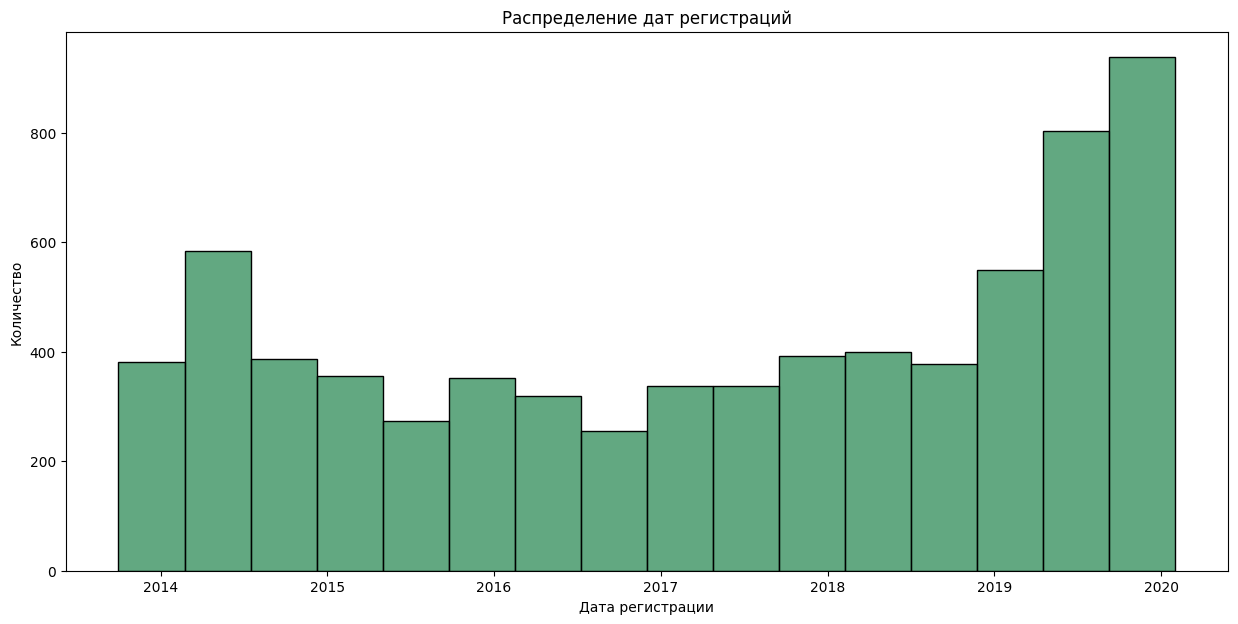

In [22]:
plt.figure(figsize=(15, 7))

sns.histplot(df_contract['begin_date'], color='seagreen').set(title=('Распределение дат регистраций'),
                                                              xlabel='Дата регистрации',
                                                              ylabel='Количество')

plt.show()

Отметим увеличение данных по зарегистрированным пользователям за период 2019-2020.

Также отметим, что данные сгруппированы по месяцам (все даты только для 1го числа месяца).

### Таргет

Признак end_date определяет таргет, так как цель проекта определить уйдет пользователь или нет.

Создадим новый признак 'terminated_contract' - который будет являться таргетом, где True (пользователь ушёл) - значение end_date любые другие данные, а False (пользователь остался) - значение end_date 'No'.

In [23]:
def make_bool(row):
    if type(row) == str:
        if row == 'No':
            return 0
        return 1
    else: return row

In [24]:
df_contract['terminated_contract'] = df_contract['end_date'].apply(make_bool)
df_contract.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,terminated_contract
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,29.85,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,1889.5,0
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.850,108.15,1
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1840.75,0
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.700,151.65,1


Посмотрим распределение таргета.

In [25]:
print('Процентальное отношение значений признака:')
print('')
print(round(df_contract['terminated_contract'].value_counts(normalize=True), 3))

Процентальное отношение значений признака:

0   0.735
1   0.265
Name: terminated_contract, dtype: float64


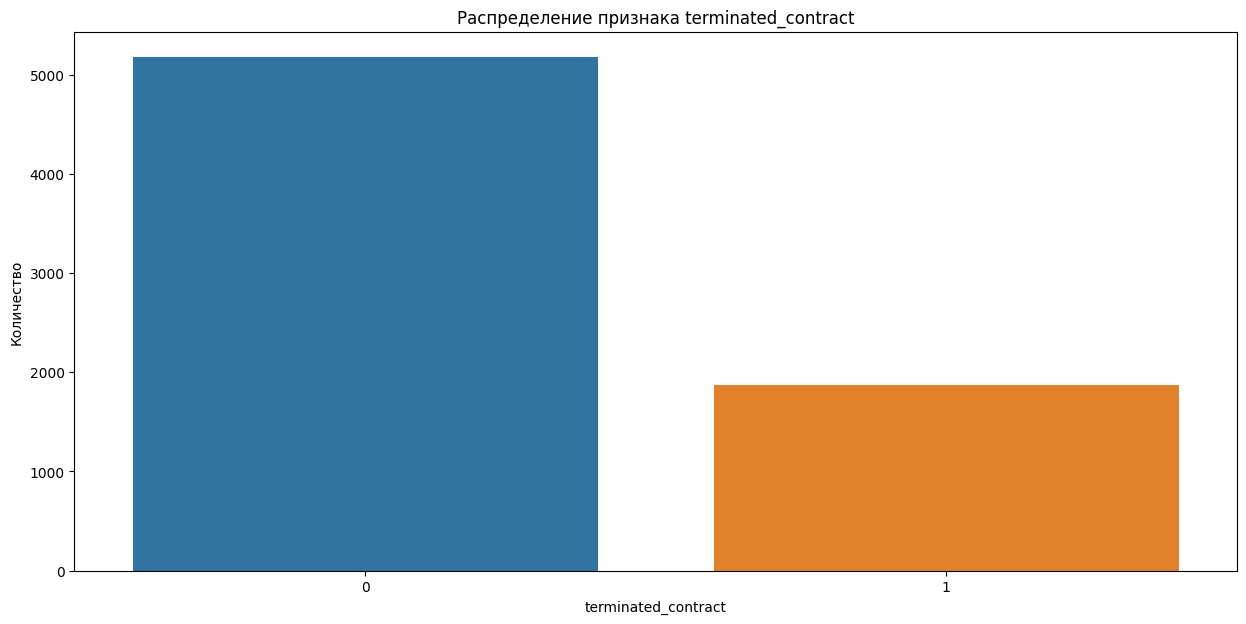

In [26]:
plt.figure(figsize=(15, 7))

sns.countplot(x=df_contract['terminated_contract']).set(title=('Распределение признака terminated_contract'),
                                                        ylabel='Количество')

plt.show()

Большинство клиентов не завершили контракты. Наблюдается явный дисбаланс таргета. Узучим подробнее при подготвоке признаков.

### Признак end_date

In [27]:
df_contract['end_date'].head()

7590-VHVEG                     No
5575-GNVDE                     No
3668-QPYBK    2019-12-01 00:00:00
7795-CFOCW                     No
9237-HQITU    2019-11-01 00:00:00
Name: end_date, dtype: object

In [28]:
df_contract['end_date'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

Заметим, что все данные, за исключением пропусков, представлены первым числом месяца.

Переведем признак end_date в datetime, замени 'No' на NaN. Также отбросим часть со временем

In [29]:
df_contract['end_date'] = df_contract['end_date'].replace('No', np.NaN)
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'])
df_contract['end_date'].head()

7590-VHVEG          NaT
5575-GNVDE          NaT
3668-QPYBK   2019-12-01
7795-CFOCW          NaT
9237-HQITU   2019-11-01
Name: end_date, dtype: datetime64[ns]

In [30]:
print(df_contract['end_date'].min())
print(df_contract['end_date'].max())

2019-10-01 00:00:00
2020-01-01 00:00:00


В отличии от данных о заключение контракта пользователями, которые происходили в промежуток с 2013 по 2020 год, клиенты уходили с 2019 по 2020.


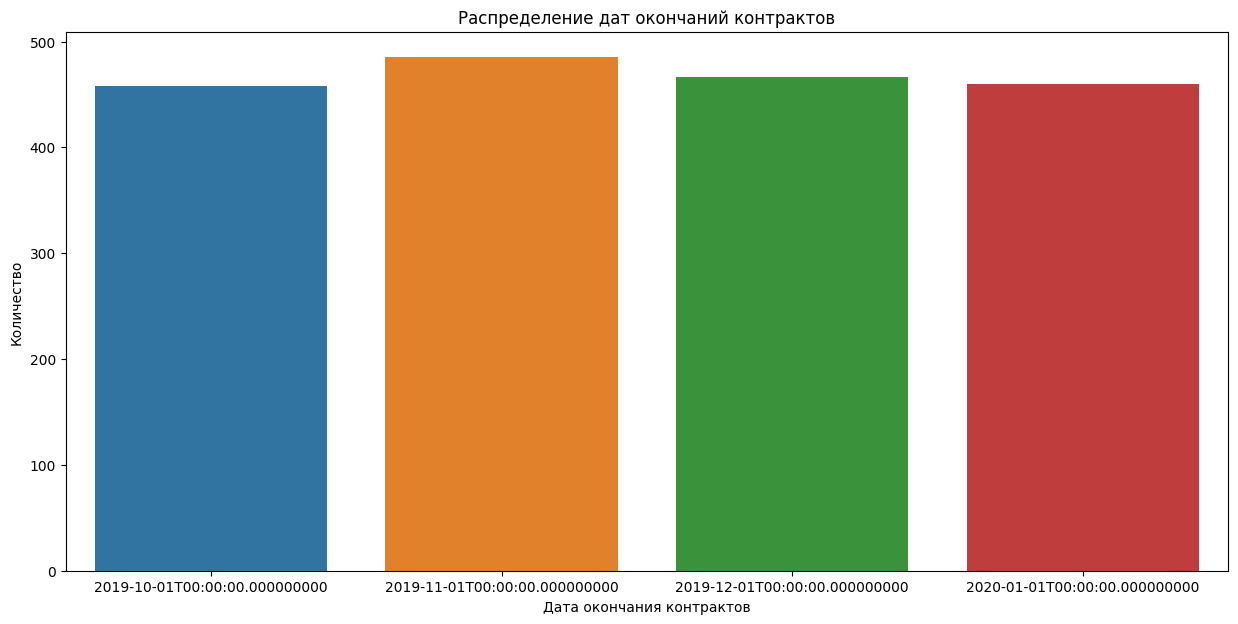

In [31]:
plt.figure(figsize=(15, 7))

sns.countplot(x=df_contract['end_date'].sort_values()).set(title=('Распределение дат окончаний контрактов'),
                                                          xlabel='Дата окончания контрактов',
                                                          ylabel='Количество')

plt.show()

In [32]:
df_contract[df_contract['terminated_contract'] == 1]['terminated_contract'].count()

1869

Очень странное распределение - 1869 человек расторгло контракт за 4 месяца. При этом эти месяцы являются последними 4 месяцами за которые предоставлены данные.

Cоздадим признак показывающий сколько дней прошло с заключения контракта клиентом.

### Признак timedelta

In [33]:
def timedelta(row, last_date):
    if row.iloc[1] is pd.NaT:
        return int((last_date - row.iloc[0]) / np.timedelta64(1, 'D'))
    else: return int((row.iloc[1] - row.iloc[0]) / np.timedelta64(1, 'D'))

In [34]:
df_contract['timedelta'] = df_contract[['begin_date', 'end_date']].apply(timedelta,
                                                                         last_date=df_contract['begin_date'].max(),
                                                                         axis=1)
df_contract.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,terminated_contract,timedelta
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.850,29.85,0,31
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.950,1889.5,0,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.850,108.15,1,61
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.300,1840.75,0,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.700,151.65,1,61


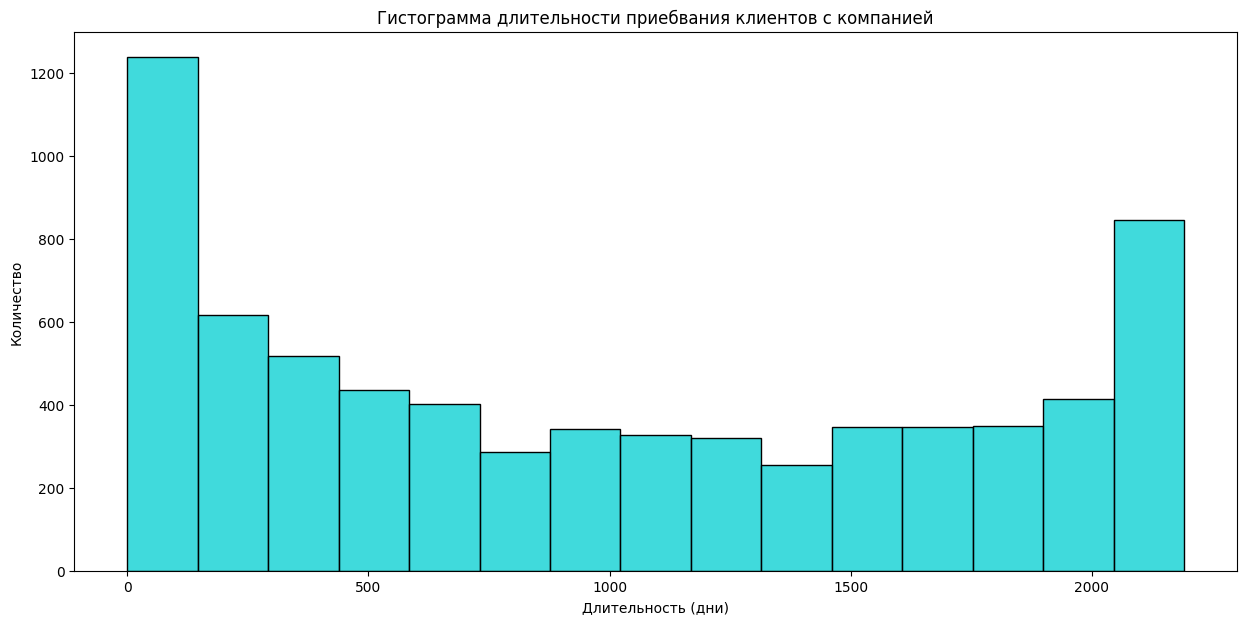

In [35]:
plt.figure(figsize=(15, 7))

sns.histplot(df_contract['timedelta'], color='darkturquoise').set(title=('Гистограмма длительности приебвания клиентов с компанией'),
                                                            xlabel='Длительность (дни)',
                                                            ylabel='Количество')

plt.show()

### Признак type

In [36]:
df_contract['type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

Значения совпадают с описанием признака в условии.

Посмотрим распределение признака.

In [37]:
print('Процентальное отношение значений признака:')
print('')
print(round(df_contract['type'].value_counts(normalize=True), 3))

Процентальное отношение значений признака:

Month-to-month   0.550
Two year         0.241
One year         0.209
Name: type, dtype: float64


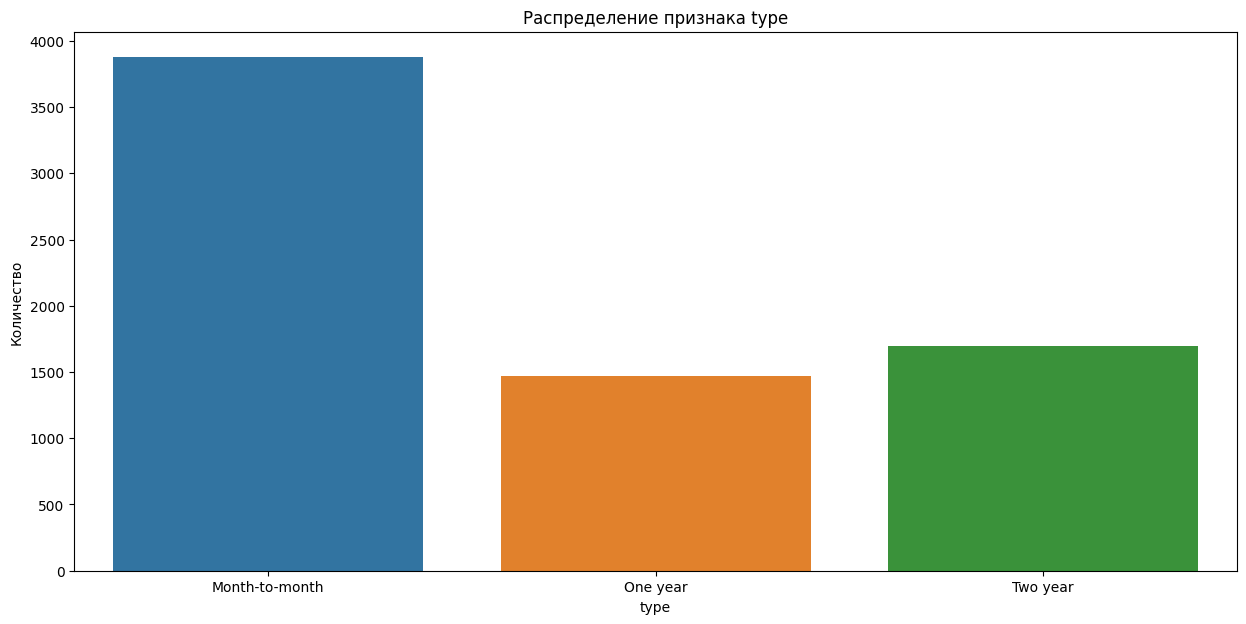

In [38]:
plt.figure(figsize=(15, 7))

sns.countplot(x=df_contract['type']).set(title=('Распределение признака type'), ylabel='Количество')

plt.show()

Большинство клиентов предпочитают ежемесячные контракты, среди длительных контракто немного больше контрактов на два года.

### Признак paperless_billing

In [39]:
df_contract['paperless_billing'].unique()

array(['Yes', 'No'], dtype=object)

Посмотрим распределение признака.

In [40]:
print('Процентальное отношение значений признака:')
print('')
print(round(df_contract['paperless_billing'].value_counts(normalize=True), 3))

Процентальное отношение значений признака:

Yes   0.592
No    0.408
Name: paperless_billing, dtype: float64


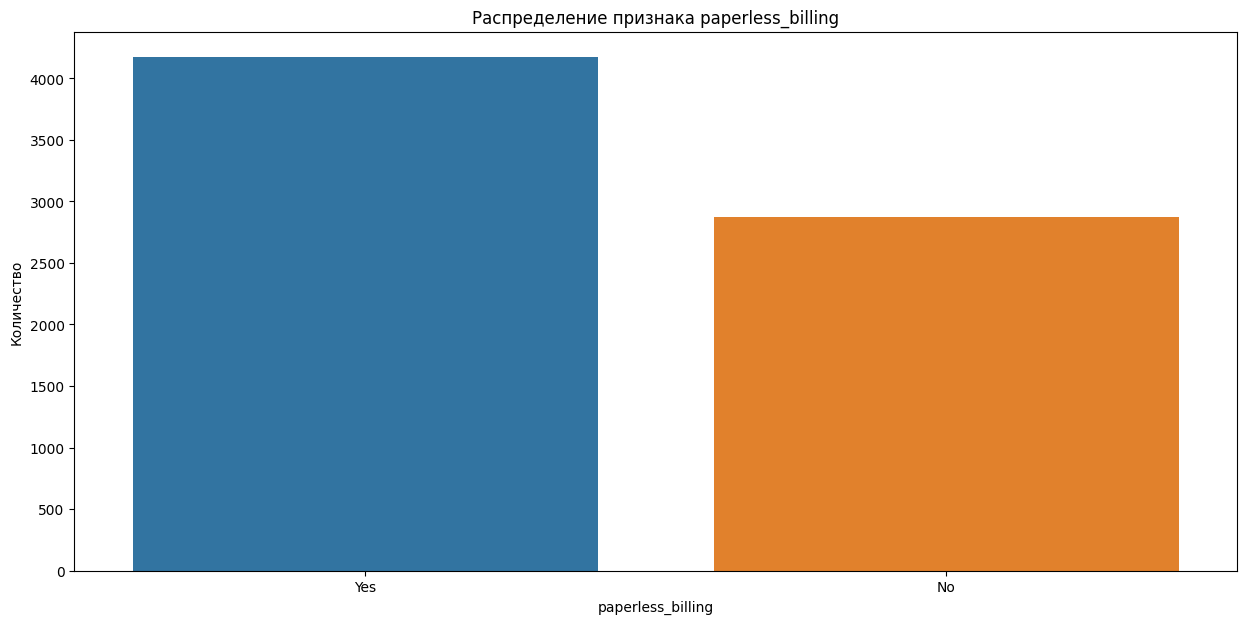

In [41]:
plt.figure(figsize=(15, 7))

sns.countplot(x=df_contract['paperless_billing']).set(title=('Распределение признака paperless_billing'),
                                                      ylabel='Количество')

plt.show()

Большинство клиентов предпочитают электронные счета.

### Признак payment_method

In [42]:
df_contract['payment_method'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Оставим как есть.

Посмотрим распределение признака.

In [43]:
print('Процентальное отношение значений признака:')
print('')
print(round(df_contract['payment_method'].value_counts(normalize=True), 3))

Процентальное отношение значений признака:

Electronic check            0.336
Mailed check                0.229
Bank transfer (automatic)   0.219
Credit card (automatic)     0.216
Name: payment_method, dtype: float64


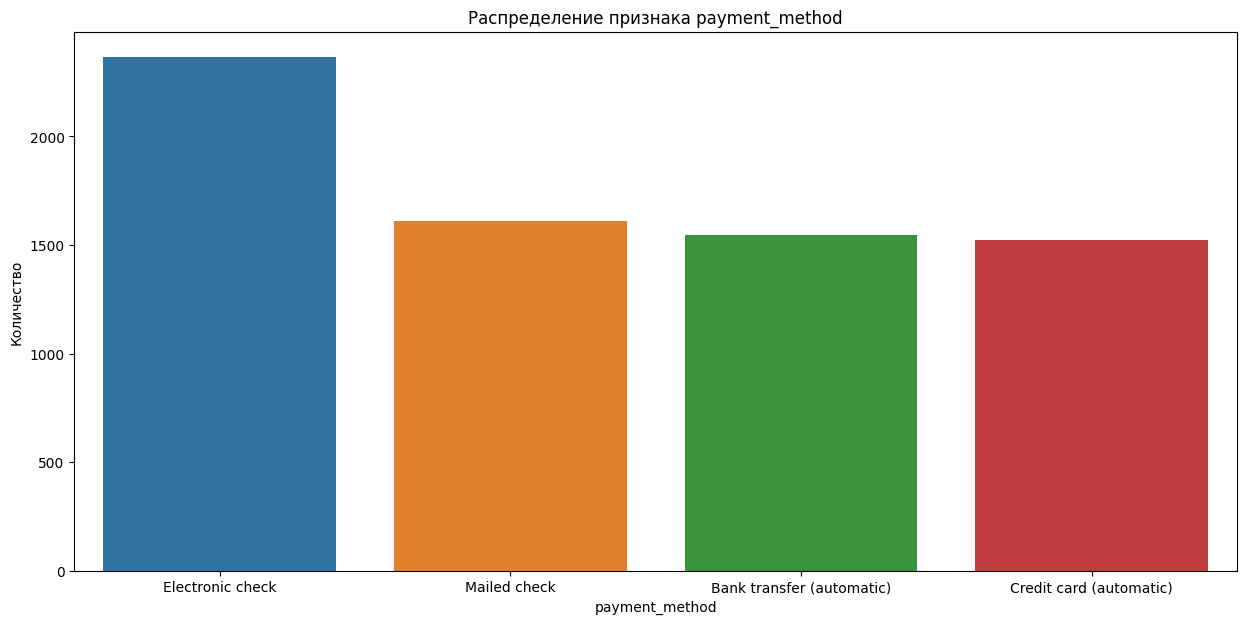

In [44]:
plt.figure(figsize=(15, 7))

sns.countplot(x=df_contract['payment_method']).set(title=('Распределение признака payment_method'),
                                                   ylabel='Количество')

plt.show()

Большинство клиентов предпочитают оплачивать по электронному счету, меньше всего выбирают автоматическую оплату с кредитной карты.

### Признак monthly_charges

In [45]:
print(df_contract['monthly_charges'].min())
print(df_contract['monthly_charges'].max())

18.25
118.75


In [46]:
df_contract['monthly_charges'].describe()

count   7043.000
mean      64.762
std       30.090
min       18.250
25%       35.500
50%       70.350
75%       89.850
max      118.750
Name: monthly_charges, dtype: float64

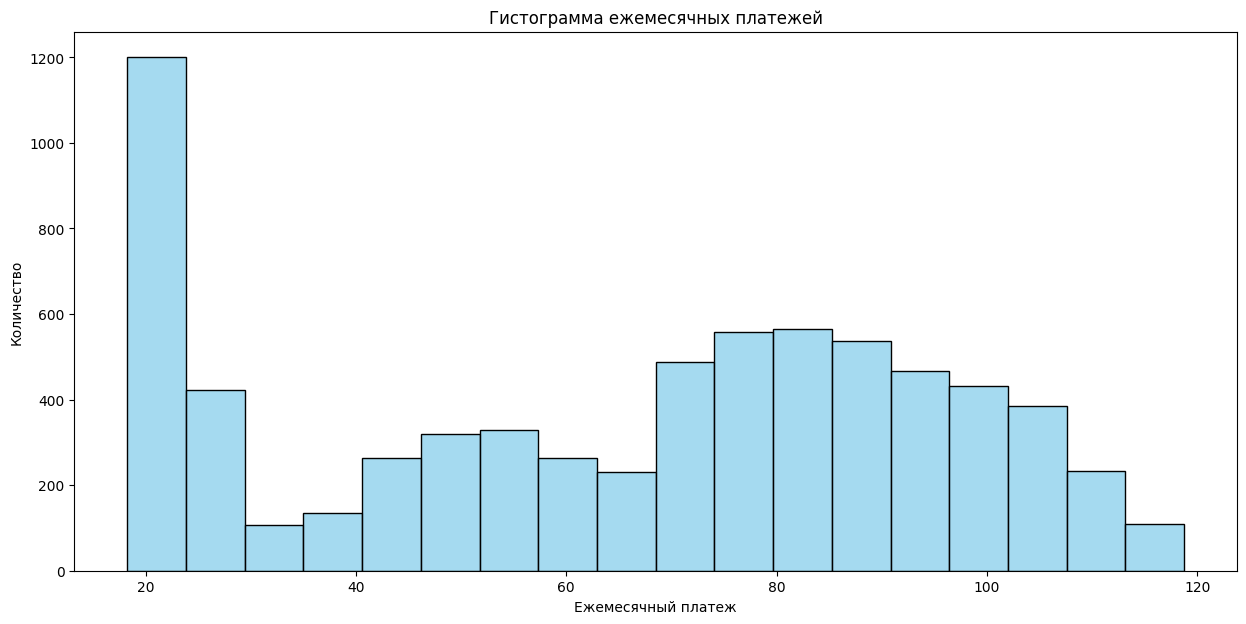

In [47]:
plt.figure(figsize=(15, 7))

sns.histplot(df_contract['monthly_charges'], color='skyblue').set(title=('Гистограмма ежемесячных платежей'),
                                                             xlabel='Ежемесячный платеж',
                                                             ylabel='Количество')

plt.show()

Видим пик около минимального значения, вероятно это люди которые пользуются только телефонией и пик ближе к медиане.

### Признак total_charges

In [48]:
df_contract['total_charges'].head()

7590-VHVEG      29.85
5575-GNVDE     1889.5
3668-QPYBK     108.15
7795-CFOCW    1840.75
9237-HQITU     151.65
Name: total_charges, dtype: object

Вначале переведём столбец во float.

Проверим возможен ли перевод.

In [49]:
def check_str_float(row):
    try:
        float(row)
        return(np.NaN)
    except ValueError:
        return(row)

In [50]:
df_contract['total_charges'].apply(check_str_float).unique()

array([nan, ' '], dtype=object)

Есть строка с пробелом, посмотрим для каких пользователей с этим значением.

In [51]:
df_contract[df_contract['total_charges'] == ' ']

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,terminated_contract,timedelta
4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.550,,0,0
3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.250,,0,0
5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.850,,0,0
4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.750,,0,0
1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.050,,0,0
7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.850,,0,0
3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.350,,0,0
2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.000,,0,0
2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.700,,0,0
4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.350,,0,0


Кажется что это пользователи зарегистрированные в последнем месяце, для которых ещё не пришел первый платёж, проверим это.

In [52]:
all(df_contract[df_contract['begin_date'] == '2020-02-01'] == df_contract[df_contract['total_charges'] == ' '])

True

Посмотрим на пользователей зарегистрировашихся в препоследнем месяце.

In [53]:
df_contract[df_contract['begin_date'] == '2020-01-01']

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,terminated_contract,timedelta
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.850,29.85,0,31
7310-EGVHZ,2020-01-01,NaT,Month-to-month,No,Bank transfer (automatic),20.200,20.2,0,31
3413-BMNZE,2020-01-01,NaT,Month-to-month,No,Bank transfer (automatic),45.250,45.25,0,31
2273-QCKXA,2020-01-01,NaT,Month-to-month,No,Mailed check,49.050,49.05,0,31
2424-WVHPL,2020-01-01,NaT,Month-to-month,No,Electronic check,74.700,74.7,0,31
...,...,...,...,...,...,...,...,...,...
1724-IQWNM,2020-01-01,NaT,Month-to-month,Yes,Mailed check,19.300,19.3,0,31
6127-IYJOZ,2020-01-01,NaT,Month-to-month,Yes,Mailed check,45.850,45.85,0,31
9108-EJFJP,2020-01-01,NaT,Month-to-month,Yes,Mailed check,53.550,53.55,0,31
5351-QESIO,2020-01-01,NaT,Month-to-month,No,Mailed check,24.200,24.2,0,31


Для них общая сумма платежа равно ежемесячеому платежу, тогда для последнего месяца заменим ' ' на 0.

In [54]:
df_contract['total_charges'] = df_contract['total_charges'].replace(' ', 0)
df_contract[df_contract['begin_date'] == '2020-02-01']

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,terminated_contract,timedelta
4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.550,0,0,0
3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.250,0,0,0
5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.850,0,0,0
4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.750,0,0,0
1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.050,0,0,0
7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.850,0,0,0
3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.350,0,0,0
2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.000,0,0,0
2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.700,0,0,0
4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.350,0,0,0


Поменяем тип.

In [55]:
df_contract['total_charges'] = df_contract['total_charges'].astype('float64')
df_contract['total_charges'].head()

7590-VHVEG     29.850
5575-GNVDE   1889.500
3668-QPYBK    108.150
7795-CFOCW   1840.750
9237-HQITU    151.650
Name: total_charges, dtype: float64

In [56]:
df_contract['total_charges'].describe()

count   7043.000
mean    2279.734
std     2266.794
min        0.000
25%      398.550
50%     1394.550
75%     3786.600
max     8684.800
Name: total_charges, dtype: float64

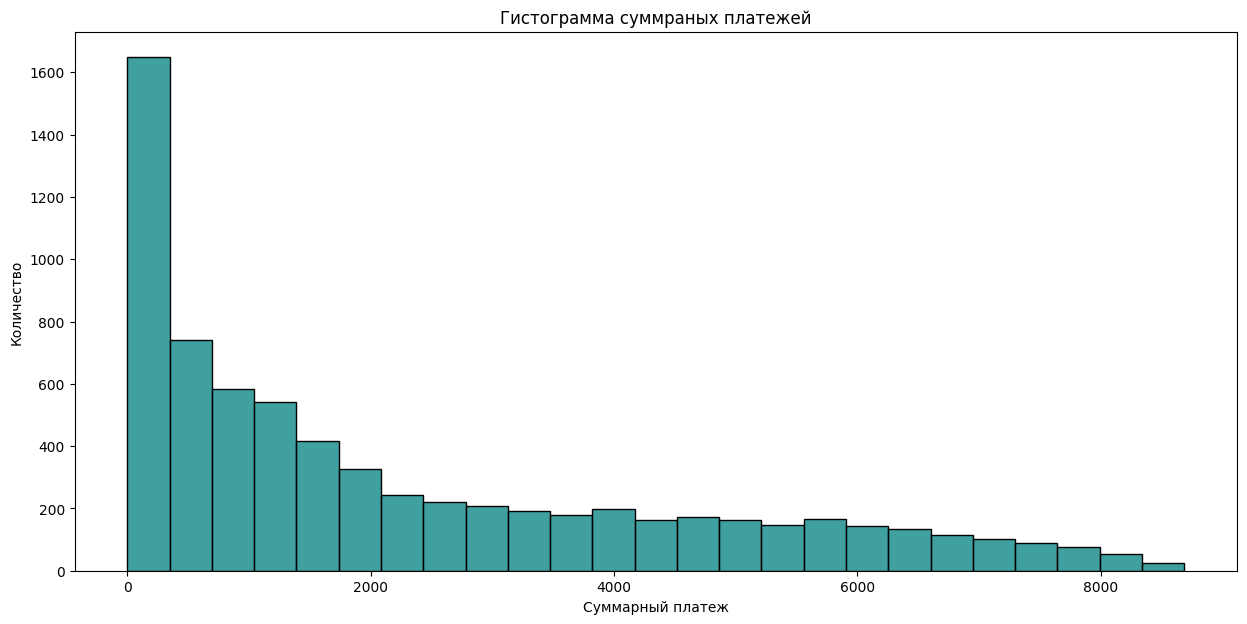

In [57]:
plt.figure(figsize=(15, 7))

sns.histplot(df_contract['total_charges'], color='teal').set(title=('Гистограмма суммраных платежей'),
                                                             xlabel='Суммарный платеж',
                                                             ylabel='Количество')

plt.show()

Суммарный платеж связан с длительностью использования услуг оператора, наблюдаем плавное снижение с увеличением суммы. Высокий пик ближе к 0 скорее всего обусловлен новыми пользователями, что подтверждается пиком пользователей в последний год у признака begin_date.

### Вывод

1. Названия признаков приведены к snake_case.
2. Выполнена проверка на дубликаты и пропуски.
3. Признаки приведены к нужным типам.
4. Таргет выделен как отдельный бинарный признак.
5. Создан новый признак показывающий сколько дней прошло со дня заключения контракта до его завершения либо до последний даты датасета.
6. В последний год зарегистрировалось много новых пользователей.
7. Все пользователи, которые завершили контракт сделали это в период 10.2019 - 01.2020.
8. Большинство пользователей не завершило контракт.
9. Большинство пользователей предпочитают ежемесячный тариф.
10. Большинство пользователей платят по электронному счету.
11. Большое количество пользователей платят маленькую ежемесячную сумму, при это существует значительное количество клиентов с большой ежемесячной суммой платежа.
12. Суммарный платеж имеет выраженный пик близко к 0, скорее всего это связано с притоком новых пользователей.

## Персональные данные

In [58]:
df_personal.head()

,gender,SeniorCitizen,Partner,Dependents
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [59]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


Приведем названия признаков к snake_case.

In [60]:
df_personal.columns = pd.Series(df_personal.columns).apply(to_snake_case)
df_personal.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

### Проверка на пропуски и дубликаты.

In [61]:
df_personal.isna().sum()

gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

In [62]:
sum(df_personal.index.duplicated())

0

Пропусков и дубликатов нет.

### Анализ признаков

In [63]:
for column in df_personal.columns:
    print('Признак', column)
    print('Уникальные значения', df_personal[column].unique())
    print('')

Признак gender
Уникальные значения ['Female' 'Male']

Признак senior_citizen
Уникальные значения [0 1]

Признак partner
Уникальные значения ['Yes' 'No']

Признак dependents
Уникальные значения ['No' 'Yes']



Признак gender

Процентальное отношение значений признака:

Male     0.505
Female   0.495
Name: gender, dtype: float64



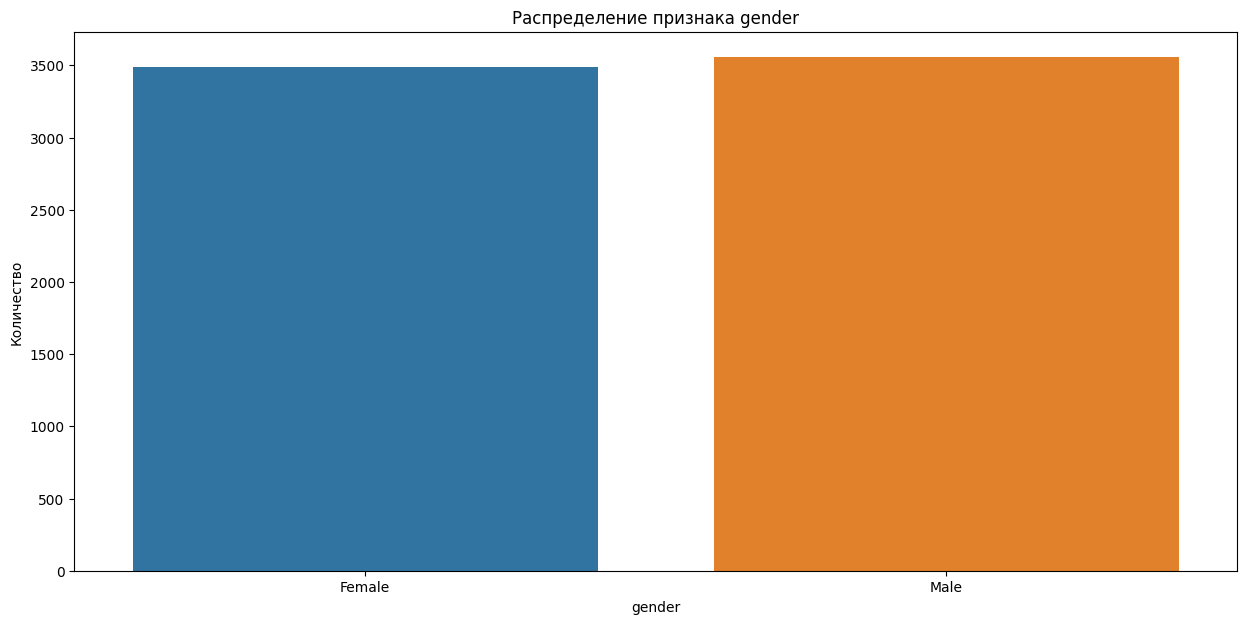


Признак senior_citizen

Процентальное отношение значений признака:

0   0.838
1   0.162
Name: senior_citizen, dtype: float64



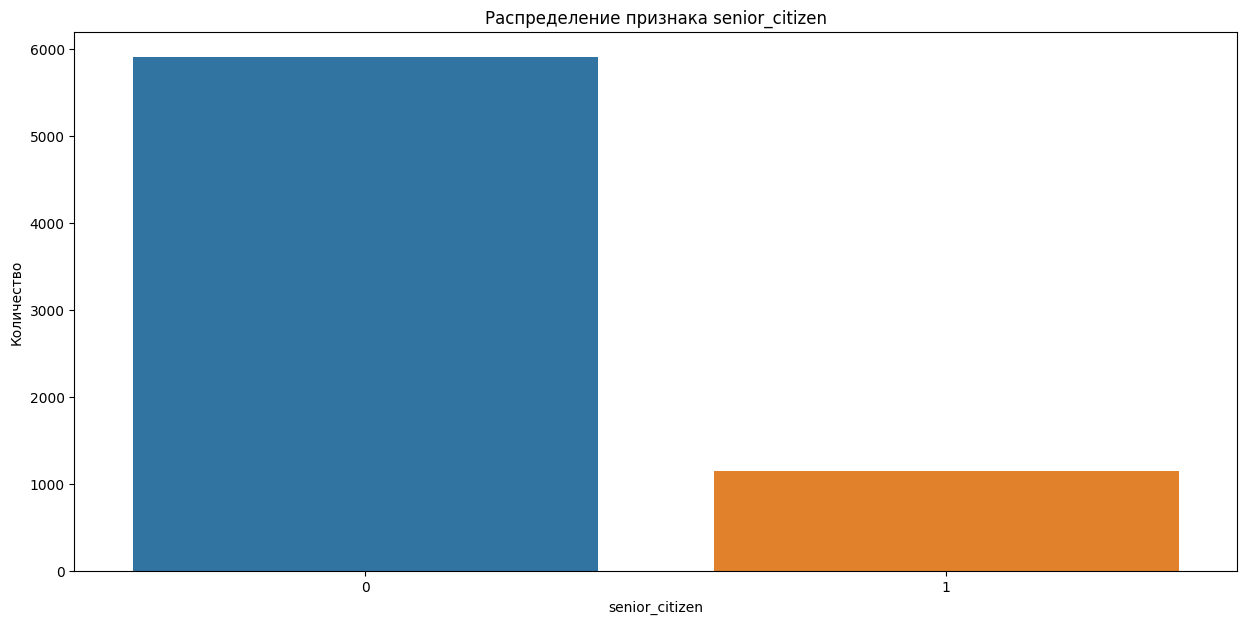


Признак partner

Процентальное отношение значений признака:

No    0.517
Yes   0.483
Name: partner, dtype: float64



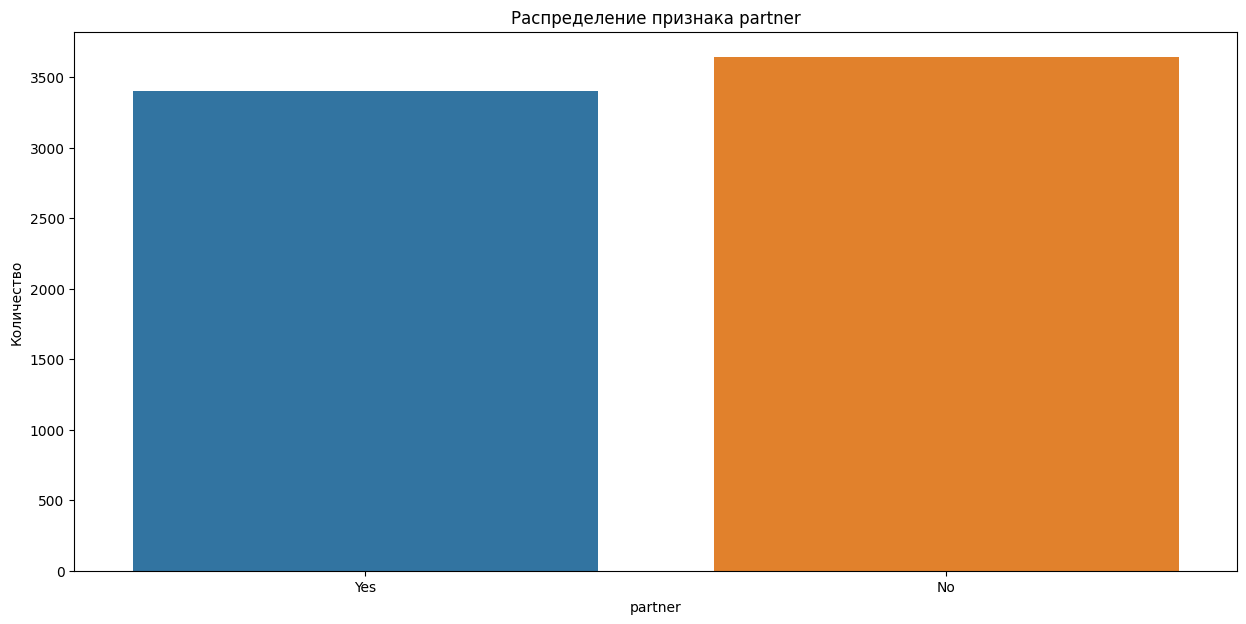


Признак dependents

Процентальное отношение значений признака:

No    0.700
Yes   0.300
Name: dependents, dtype: float64



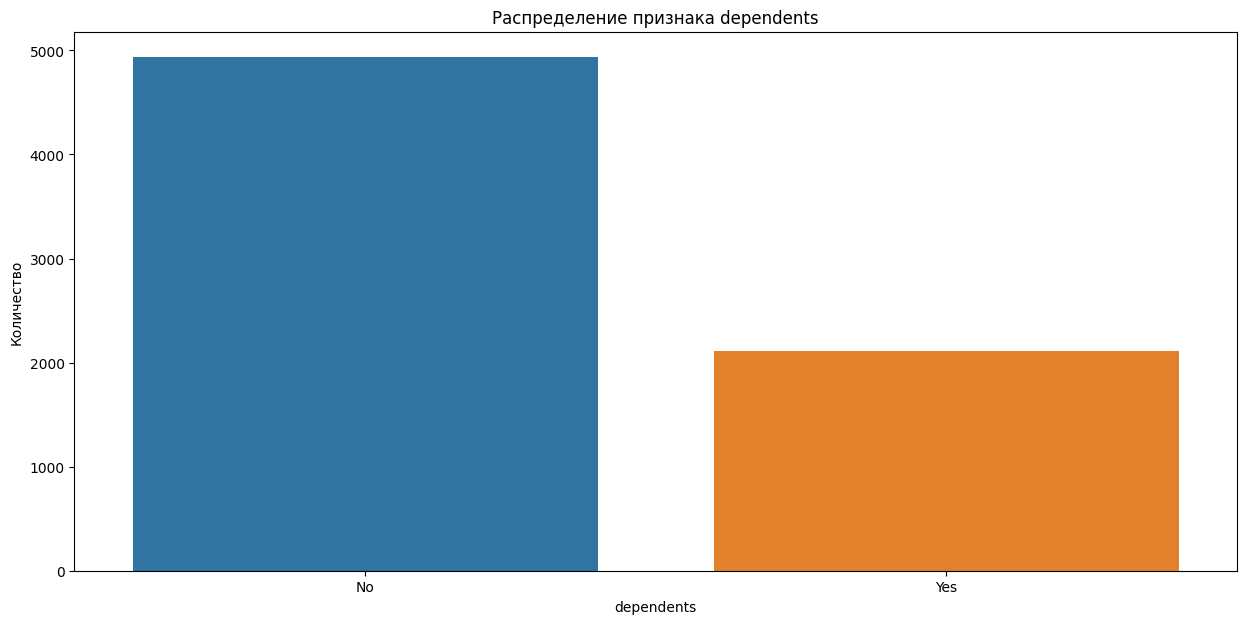

In [64]:
for column in df_personal.columns:
    print('Признак', column)
    print('')
    print('Процентальное отношение значений признака:')
    print('')
    print(round(df_personal[column].value_counts(normalize=True), 3))
    print('')

    plt.figure(figsize=(15, 7))

    sns.countplot(x=df_personal[column]).set(title=(f'Распределение признака {column}'), ylabel='Количество')

    plt.show()
    print('')

### Вывод

1. Названия признаков приведены к snake_case.
2. Выполнена проверка на дубликаты и пропуски.
3. У большинства пользователей оптоволоконный интернет.
4. Большинство пользователей малдше пенсионного возраста и не имеют иждевенцев.

## Интернет

In [65]:
df_internet.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [66]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


Приведем названия признаков к snake_case.

In [67]:
df_internet.columns = pd.Series(df_internet.columns).apply(to_snake_case)
df_internet.columns

Index(['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

### Проверка на пропуски и дубликаты.

In [68]:
df_internet.isna().sum()

internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

In [69]:
sum(df_internet.index.duplicated())

0

Пропусков и дубликатов нет.

### Анализ признаков

In [70]:
for column in df_internet.columns:
    print('Признак', column)
    print('Уникальные значения', df_internet[column].unique())
    print('')

Признак internet_service
Уникальные значения ['DSL' 'Fiber optic']

Признак online_security
Уникальные значения ['No' 'Yes']

Признак online_backup
Уникальные значения ['Yes' 'No']

Признак device_protection
Уникальные значения ['No' 'Yes']

Признак tech_support
Уникальные значения ['No' 'Yes']

Признак streaming_tv
Уникальные значения ['No' 'Yes']

Признак streaming_movies
Уникальные значения ['No' 'Yes']



Признак internet_service

Процентальное отношение значений признака:

Fiber optic   0.561
DSL           0.439
Name: internet_service, dtype: float64



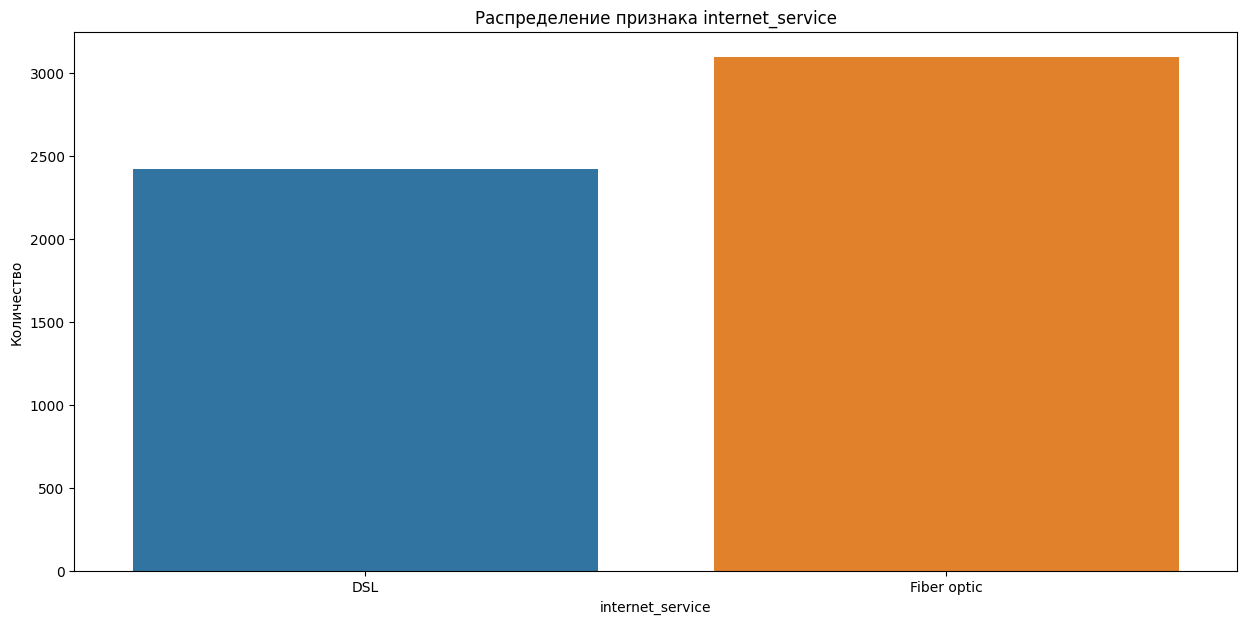


Признак online_security

Процентальное отношение значений признака:

No    0.634
Yes   0.366
Name: online_security, dtype: float64



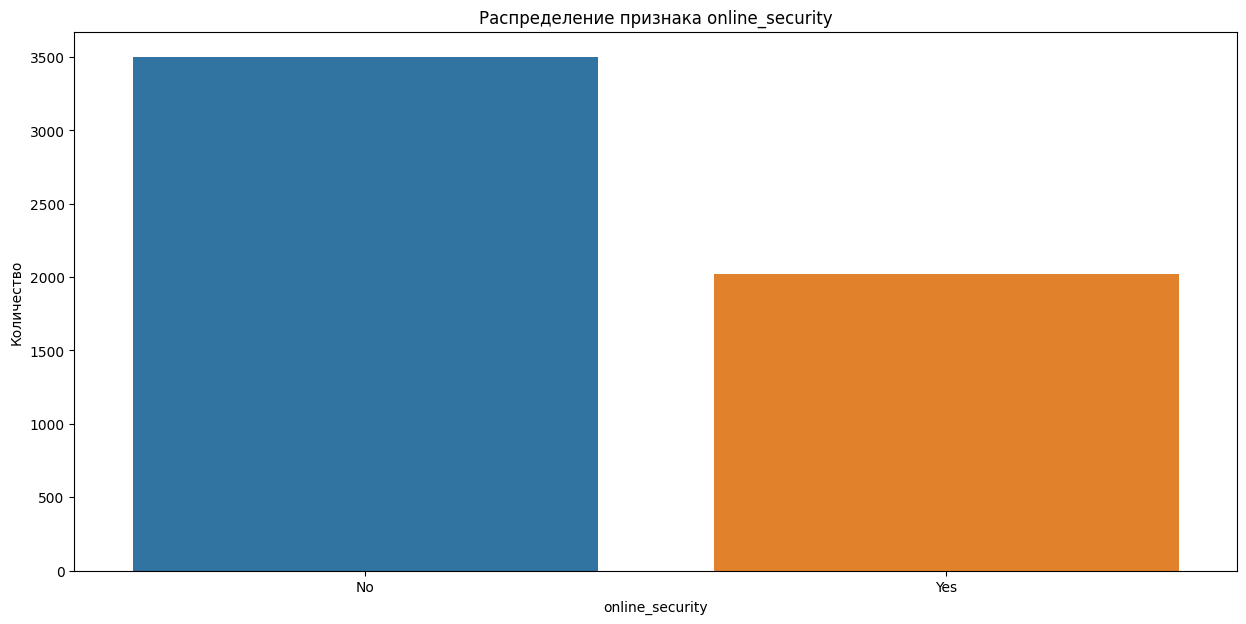


Признак online_backup

Процентальное отношение значений признака:

No    0.560
Yes   0.440
Name: online_backup, dtype: float64



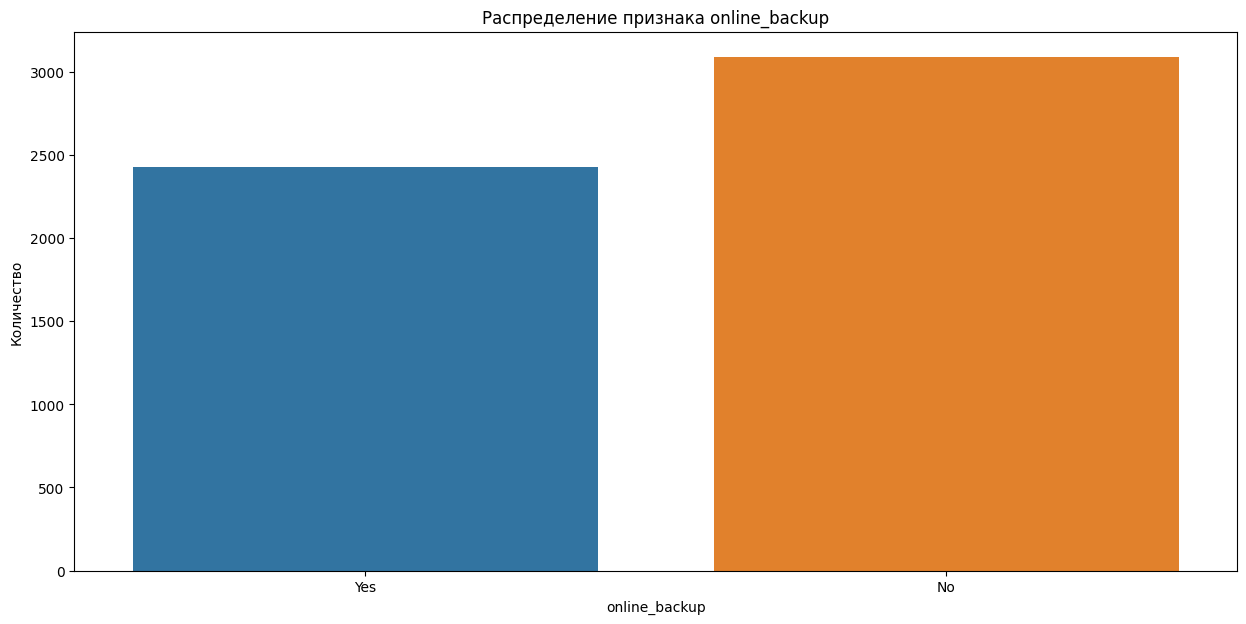


Признак device_protection

Процентальное отношение значений признака:

No    0.561
Yes   0.439
Name: device_protection, dtype: float64



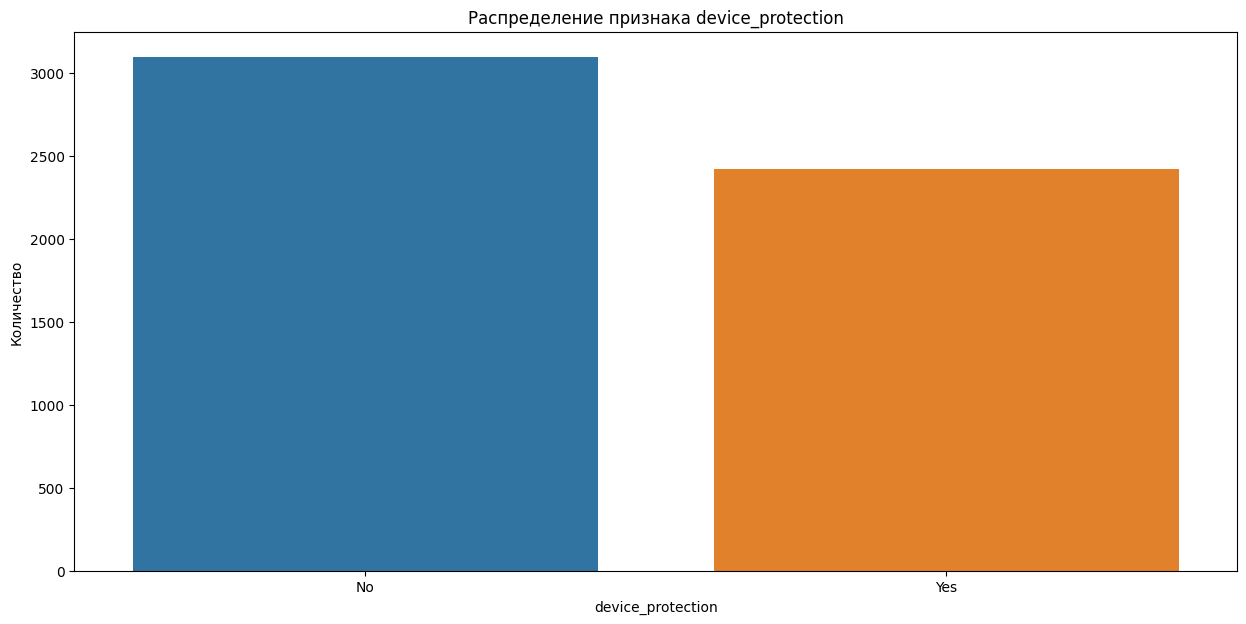


Признак tech_support

Процентальное отношение значений признака:

No    0.630
Yes   0.370
Name: tech_support, dtype: float64



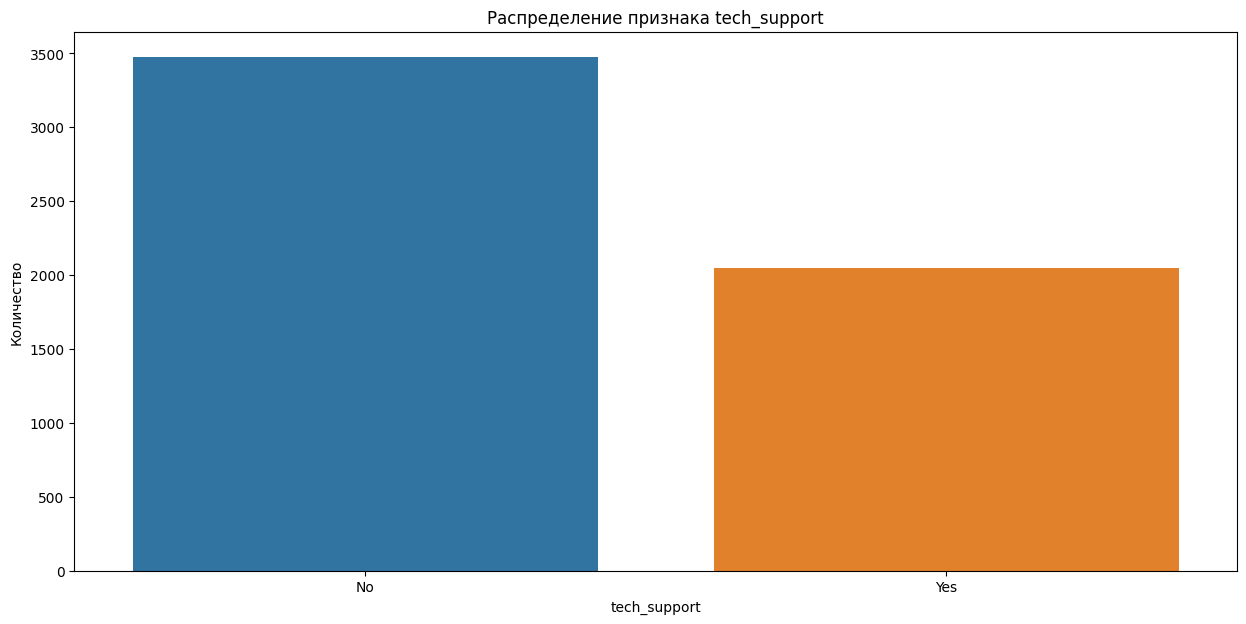


Признак streaming_tv

Процентальное отношение значений признака:

No    0.509
Yes   0.491
Name: streaming_tv, dtype: float64



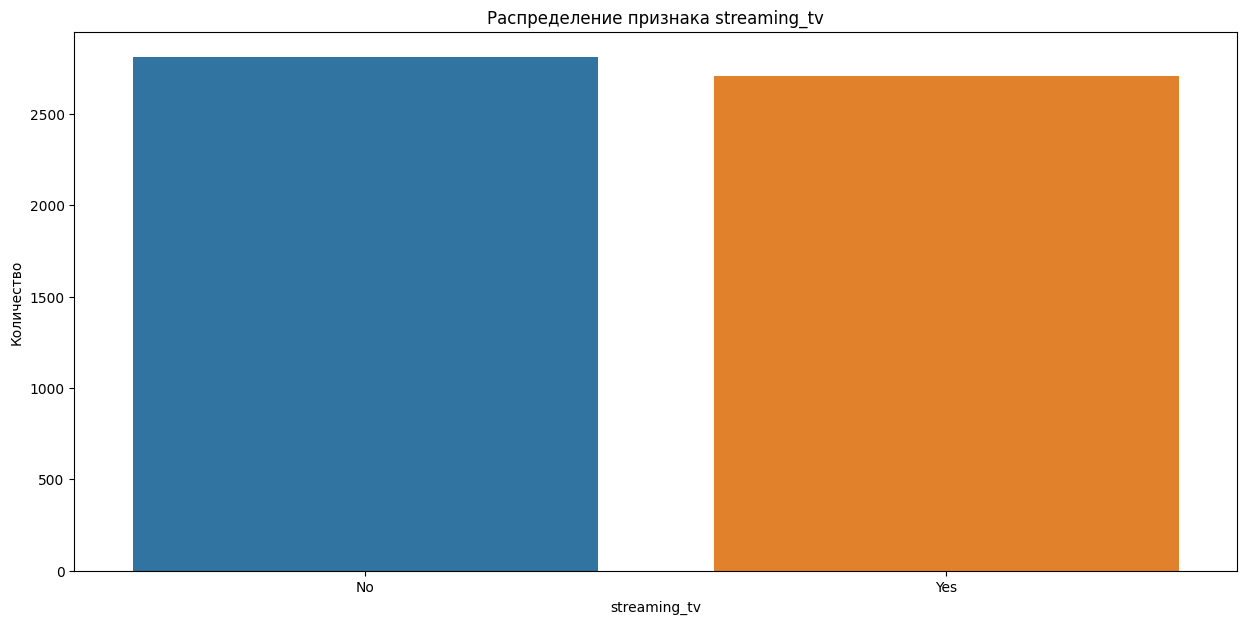


Признак streaming_movies

Процентальное отношение значений признака:

No    0.505
Yes   0.495
Name: streaming_movies, dtype: float64



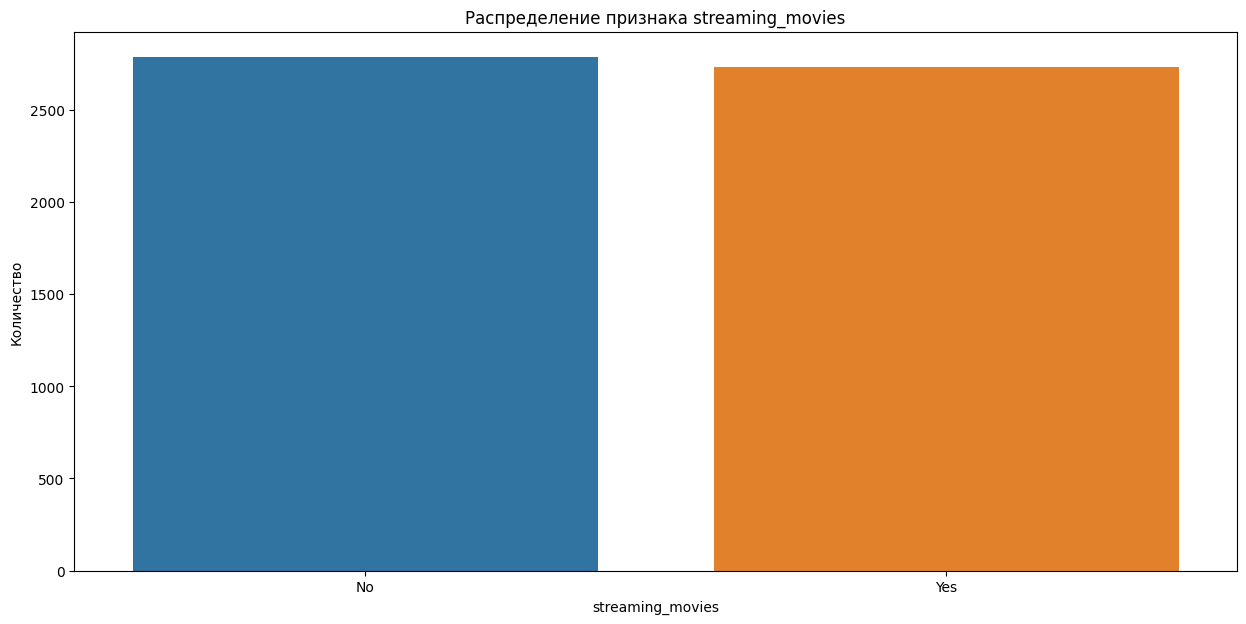

In [71]:
for column in df_internet.columns:
    print('Признак', column)
    print('')
    print('Процентальное отношение значений признака:')
    print('')
    print(round(df_internet[column].value_counts(normalize=True), 3))
    print('')

    plt.figure(figsize=(15, 7))

    sns.countplot(x=df_internet[column]).set(title=(f'Распределение признака {column}'), ylabel='Количество')

    plt.show()
    print('')

### Вывод

1. Названия признаков приведены к snake_case.
2. Выполнена проверка на дубликаты и пропуски.
3. Признаки приведены к нужным типам.
4. У большинства пользователей оптоволоконный интернет.
5. Наименее популярные услуги: антивирус и линия выделенной техподдержки.

## Телефония

In [72]:
df_phone.head()

,MultipleLines
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [73]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


Приведем названия признаков к snake_case.

In [74]:
df_phone.columns = pd.Series(df_phone.columns).apply(to_snake_case)
df_phone.columns

Index(['multiple_lines'], dtype='object')

### Проверка на пропуски и дубликаты.

In [75]:
df_phone.isna().sum()

multiple_lines    0
dtype: int64

In [76]:
sum(df_phone.index.duplicated())

0

Пропусков и дубликатов нет.

### Анализ признаков

In [77]:
df_phone['multiple_lines'].unique()

array(['No', 'Yes'], dtype=object)

In [78]:
print('Процентальное отношение значений признака:')
print('')
print(round(df_phone['multiple_lines'].value_counts(normalize=True), 3))

Процентальное отношение значений признака:

No    0.533
Yes   0.467
Name: multiple_lines, dtype: float64


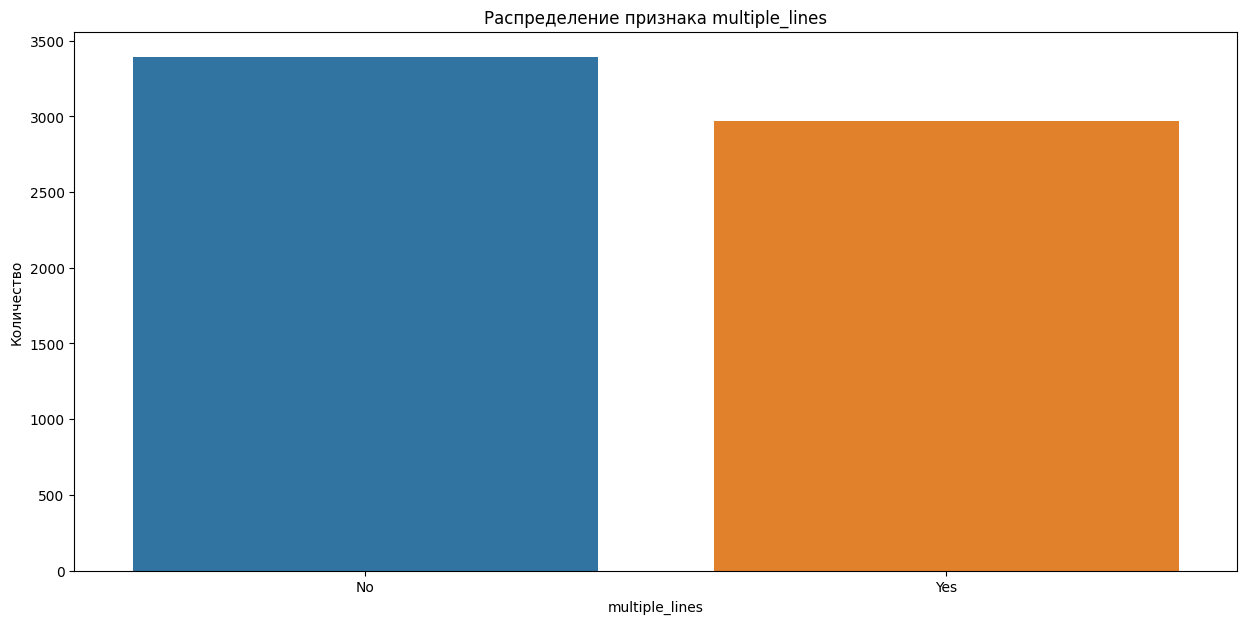

In [79]:
plt.figure(figsize=(15, 7))

sns.countplot(x=df_phone['multiple_lines']).set(title=('Распределение признака multiple_lines'), ylabel='Количество')

plt.show()

### Вывод

1. Названия признаков приведены к snake_case.
2. Выполнена проверка на дубликаты и пропуски.
3. Признаки приведены к нужным типам.
4. У почти половины пользователей телефон подключен к нескольким линиям.

## Вывод

1. Названия признаков приведены к snake_case.
2. Выполнена проверка на дубликаты и пропуски.
3. Признаки приведены к нужным типам.
4. Таргет сделан бинарным признаком.
5. Признаки рассмотрены на аномалии и построены распределения.

# Подготовка данных

## Объединение датафреймов

Объединим датафреймы по customer_id.

In [80]:
print(df_contract.info())
print(df_personal.info())
print(df_internet.info())
print(df_phone.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   begin_date           7043 non-null   datetime64[ns]
 1   end_date             1869 non-null   datetime64[ns]
 2   type                 7043 non-null   object        
 3   paperless_billing    7043 non-null   object        
 4   payment_method       7043 non-null   object        
 5   monthly_charges      7043 non-null   float64       
 6   total_charges        7043 non-null   float64       
 7   terminated_contract  7043 non-null   int64         
 8   timedelta            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 808.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ----

Так как таргет находится в df_contract примем его за основной и будем добавлять к нему другие датафреймы левым присоединением.

In [81]:
df = df_contract.join(df_personal)
df = df.join(df_internet)
df = df.join(df_phone)
df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,terminated_contract,timedelta,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.850,29.850,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.950,1889.500,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.850,108.150,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.300,1840.750,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.700,151.650,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Проверим объединение.

Сохранность столбцов.

In [82]:
df.columns.to_list() == (df_contract.columns.to_list() +
                         df_personal.columns.to_list() +
                         df_internet.columns.to_list() +
                         df_phone.columns.to_list())

True

Сохранность строк.

In [83]:
all(df.index == df_contract.index)

True

Объединение правильное.

In [84]:
df.isna().sum()

begin_date                0
end_date               5174
type                      0
paperless_billing         0
payment_method            0
monthly_charges           0
total_charges             0
terminated_contract       0
timedelta                 0
gender                    0
senior_citizen            0
partner                   0
dependents                0
internet_service       1526
online_security        1526
online_backup          1526
device_protection      1526
tech_support           1526
streaming_tv           1526
streaming_movies       1526
multiple_lines          682
dtype: int64

Так как не все клиенты одновременно пользуются услугами телефонии и интернета, в датафрейме появились пропуски.

Из анализа данных видно, что пропуски в бинарных категорийных признаках с уникальными значениями 'Yes' и 'No'. Так как пропуск означает, что клиент не пользуется услугами заполним пропуски 'No'.

In [85]:
df = df.fillna('No')

Также отбросим признаки begin_date и end_date, которые не будут использоваться в моделях.

In [86]:
df = df.drop(['begin_date', 'end_date'], axis=1)
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,terminated_contract,timedelta,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
7590-VHVEG,Month-to-month,Yes,Electronic check,29.850,29.850,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.950,1889.500,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.850,108.150,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.300,1840.750,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.700,151.650,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Посмотрим зависимость между признаками и таргетом в объединенном датафрейме.

In [87]:
df_current = df[df['terminated_contract'] == 0].copy()
df_terminated = df[df['terminated_contract'] == 1].copy()

print(df.shape)
print(df_current.shape, df_terminated.shape)

(7043, 19)
(5174, 19) (1869, 19)


In [88]:
columns_cont = ['monthly_charges', 'total_charges', 'timedelta']
columns_to_del = columns_cont + ['terminated_contract']
columns_cat = df.drop(columns_to_del, axis=1).columns.to_list()

print(columns_cont)
print(columns_cat)

['monthly_charges', 'total_charges', 'timedelta']
['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


<ipython-input-89-eb7d76285e11>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_current[column], shade=True, color='teal', label='Текущие клиенты')
<ipython-input-89-eb7d76285e11>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_terminated[column], shade=True, color='orange', label='Бывшие клиенты')


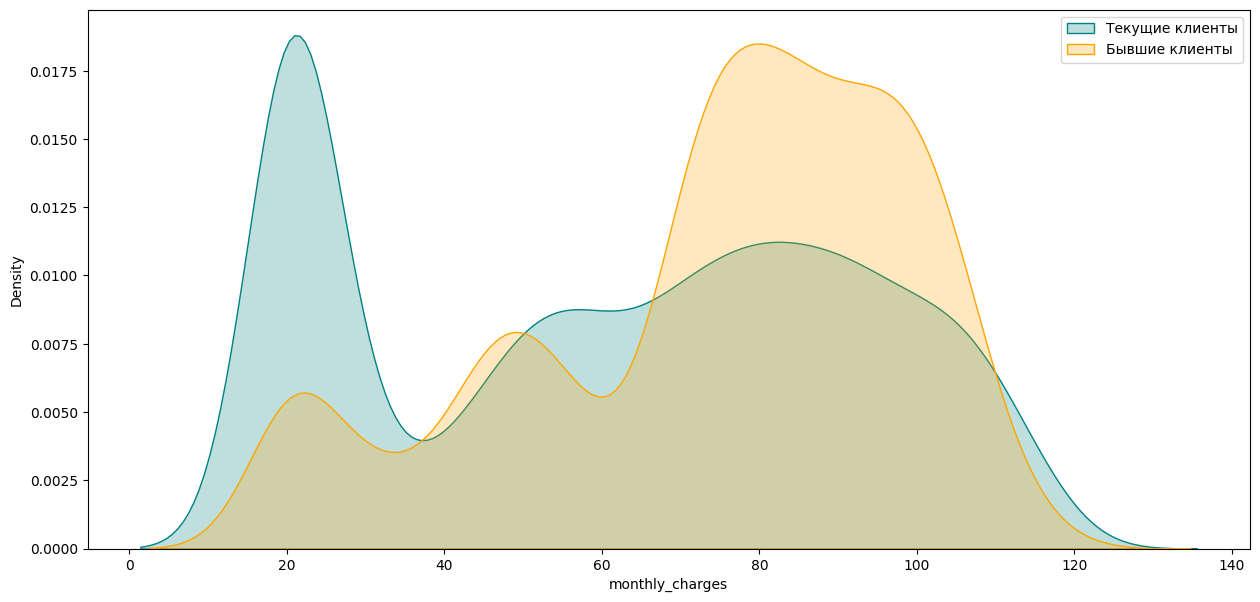

<ipython-input-89-eb7d76285e11>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_current[column], shade=True, color='teal', label='Текущие клиенты')
<ipython-input-89-eb7d76285e11>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_terminated[column], shade=True, color='orange', label='Бывшие клиенты')


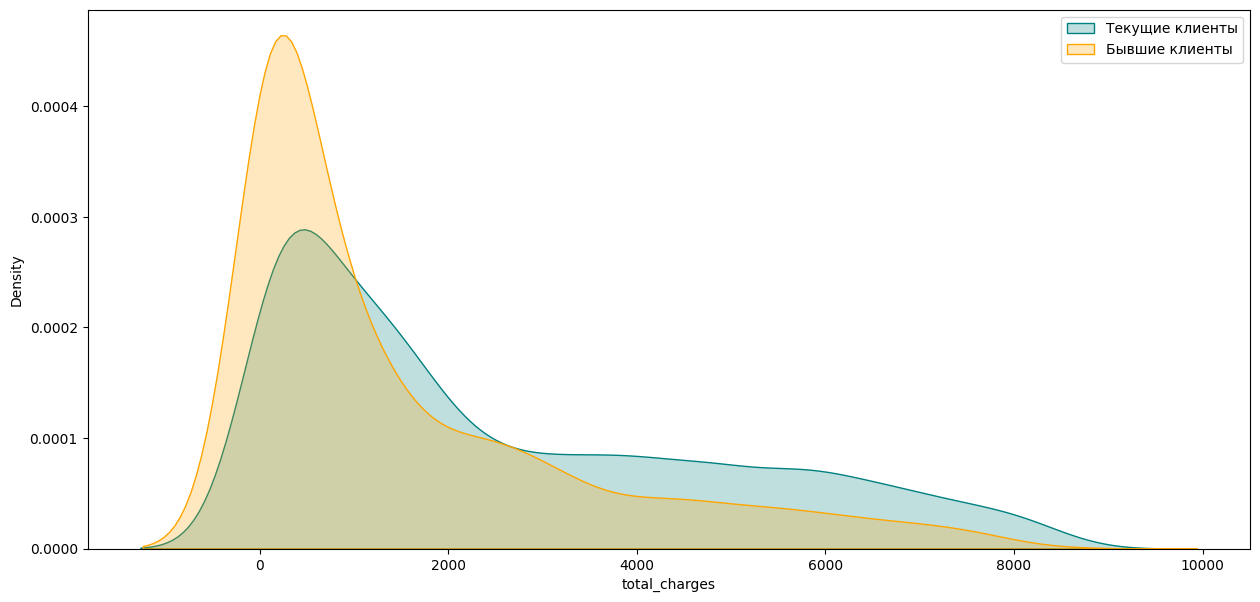

<ipython-input-89-eb7d76285e11>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_current[column], shade=True, color='teal', label='Текущие клиенты')
<ipython-input-89-eb7d76285e11>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_terminated[column], shade=True, color='orange', label='Бывшие клиенты')


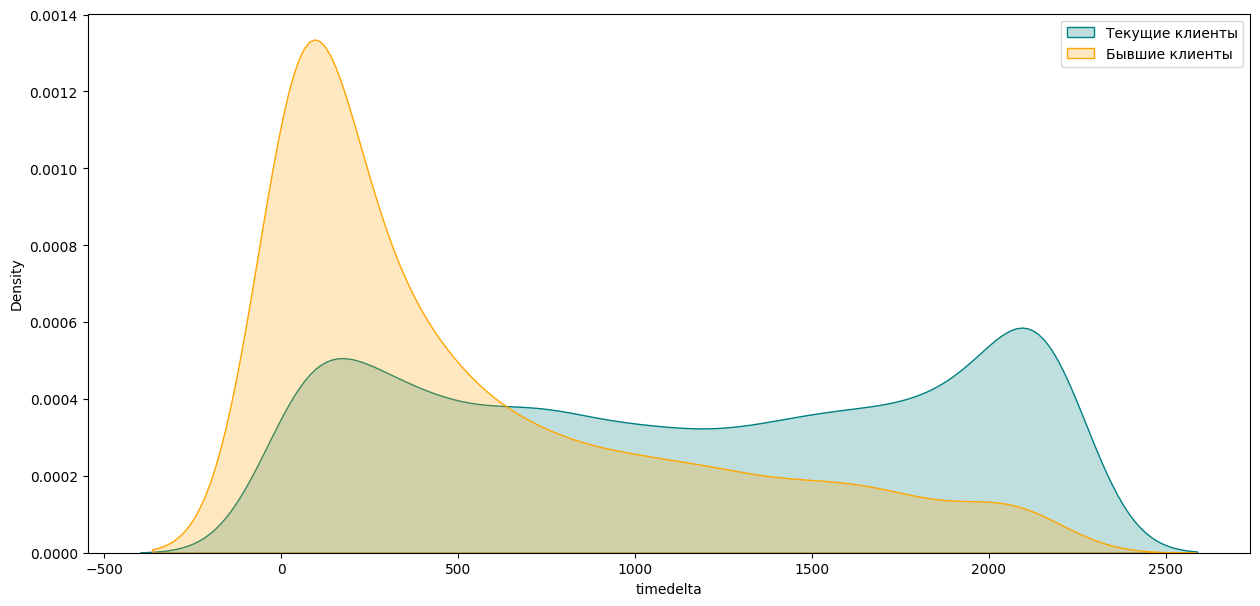

In [89]:
for column in columns_cont:

    plt.figure(figsize=(15, 7))

    sns.kdeplot(df_current[column], shade=True, color='teal', label='Текущие клиенты')
    sns.kdeplot(df_terminated[column], shade=True, color='orange', label='Бывшие клиенты')

    plt.legend()
    plt.show()

1. Пик распредления стоимосиь ежемесячных услуг у текущих клиентов сильно смещен влево от пика чем у ушедших, т.е. в среднем текущие клиенты тратят меньше в месяц чем ушедшие. Возможно траты на ненужные услуги подтолкнули их к уходу.
2. Пик распределения суммарных платежей у бывших клиентов смещен влево относительно пика у текущих клиентов. У текущих клиентов выше средний сумарный платеж.
3. Пик распределения времени с заключения контракта у бывших клиентов сильно смещен влево, в то же время распределение времения для текущих клиентов более равномерное. Чем дольше рользователь является клиентом компании, тем меньше риск, что он уйдет.

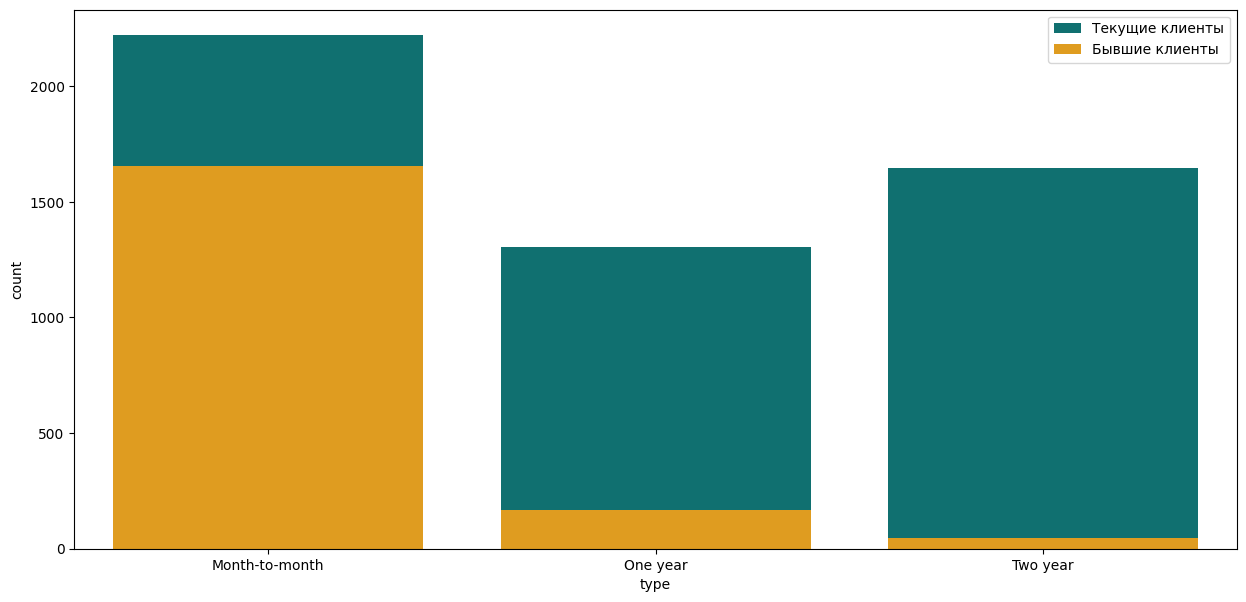

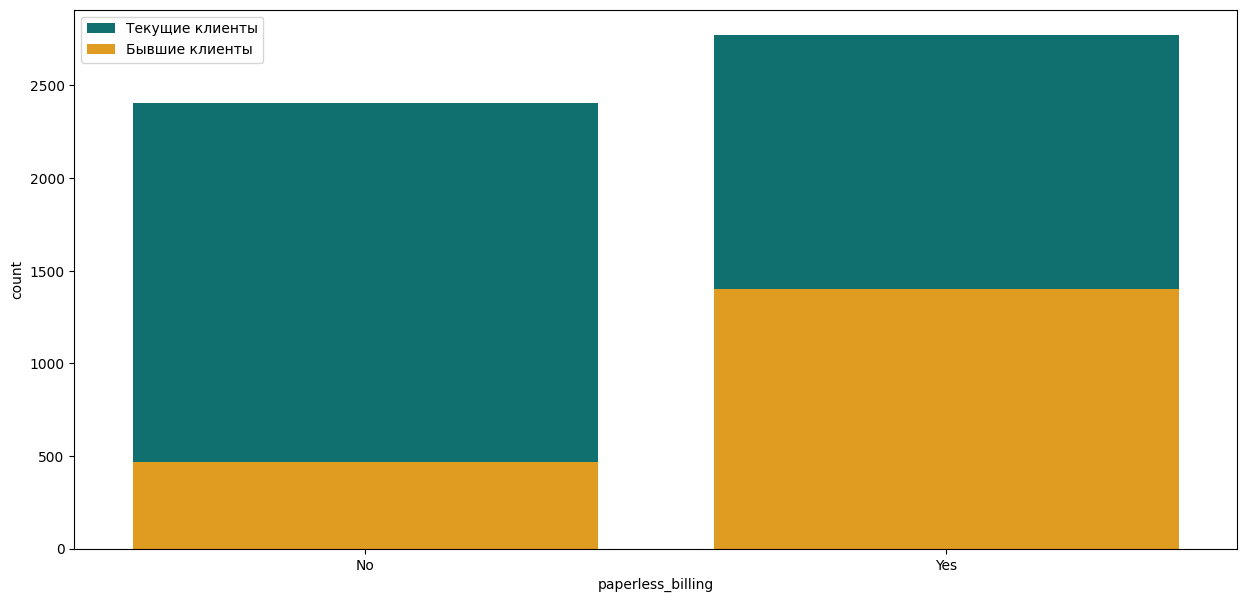

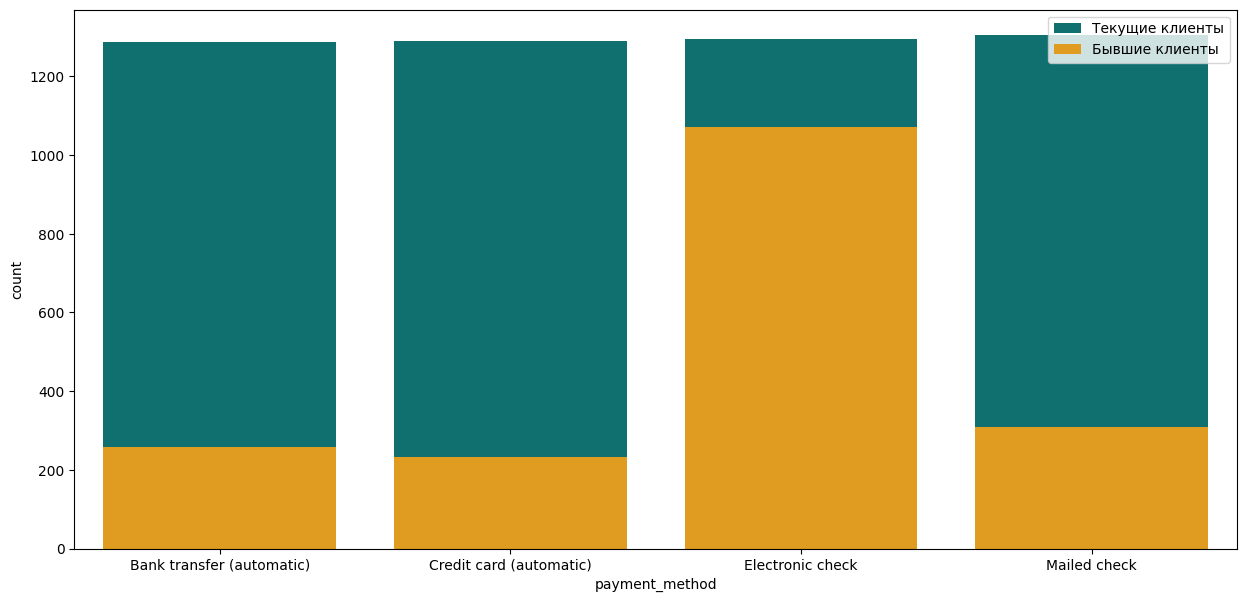

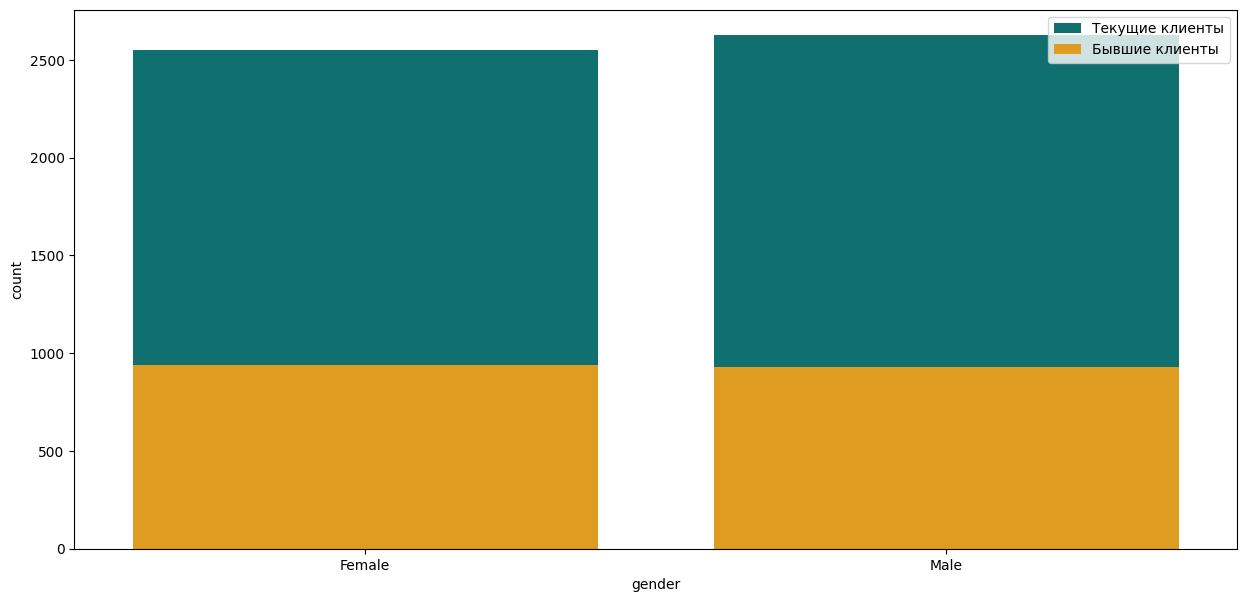

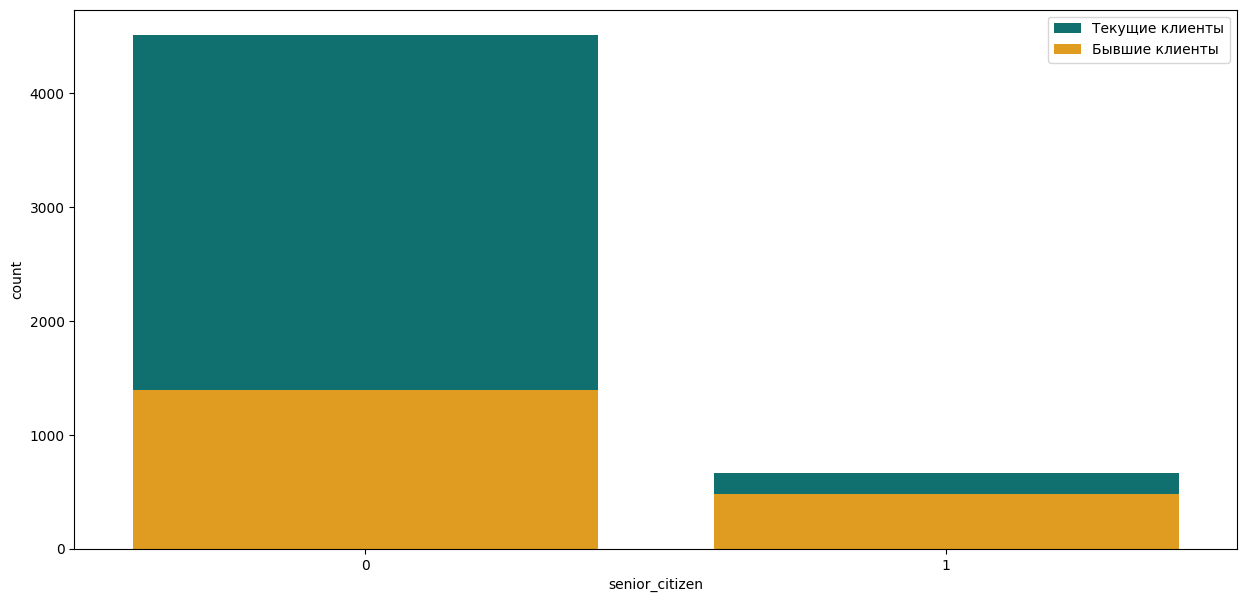

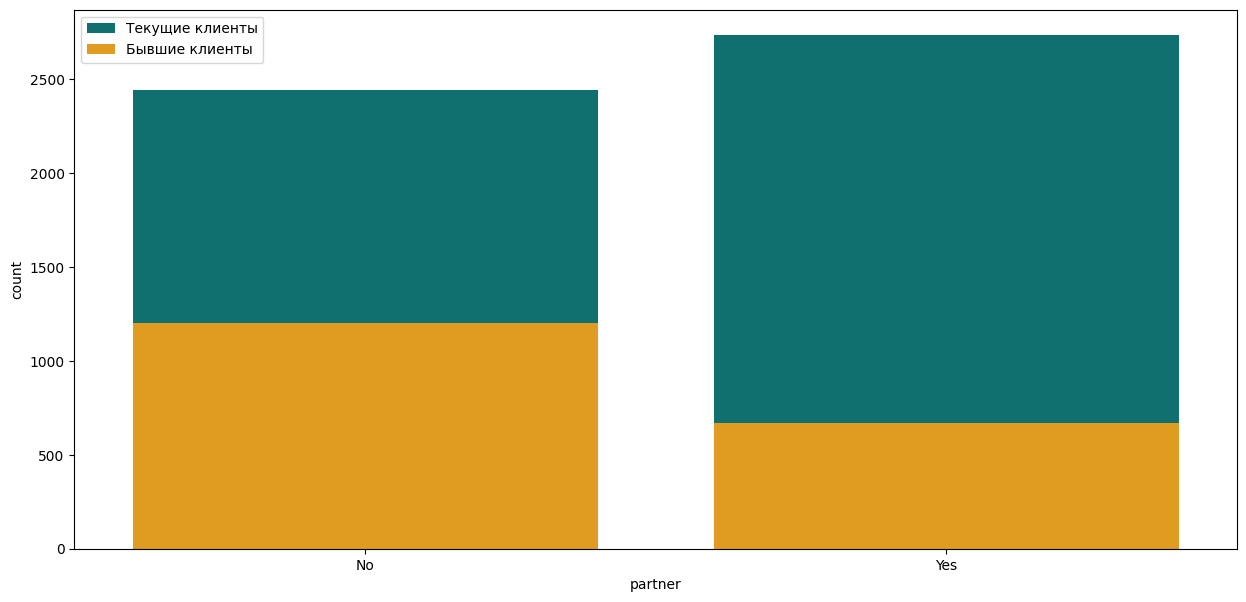

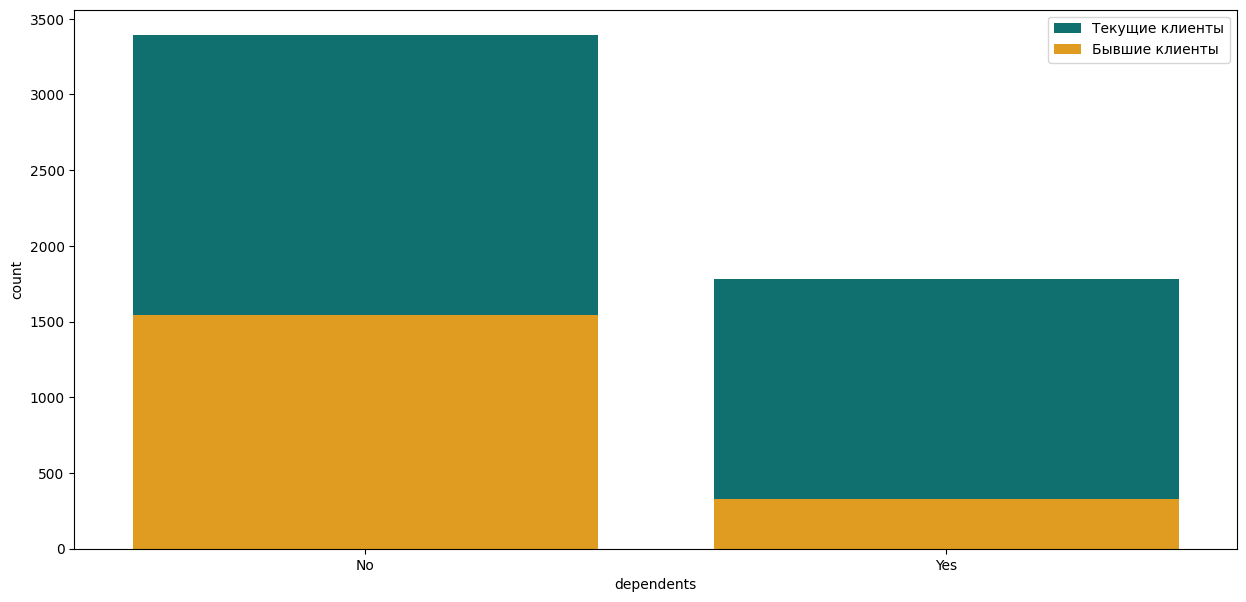

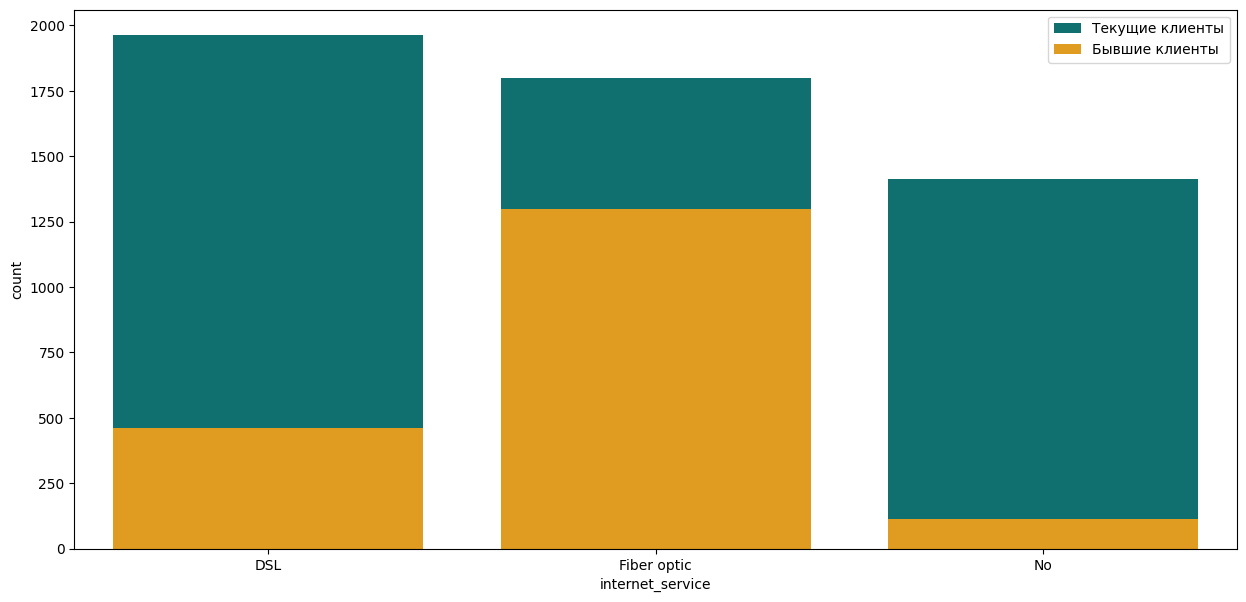

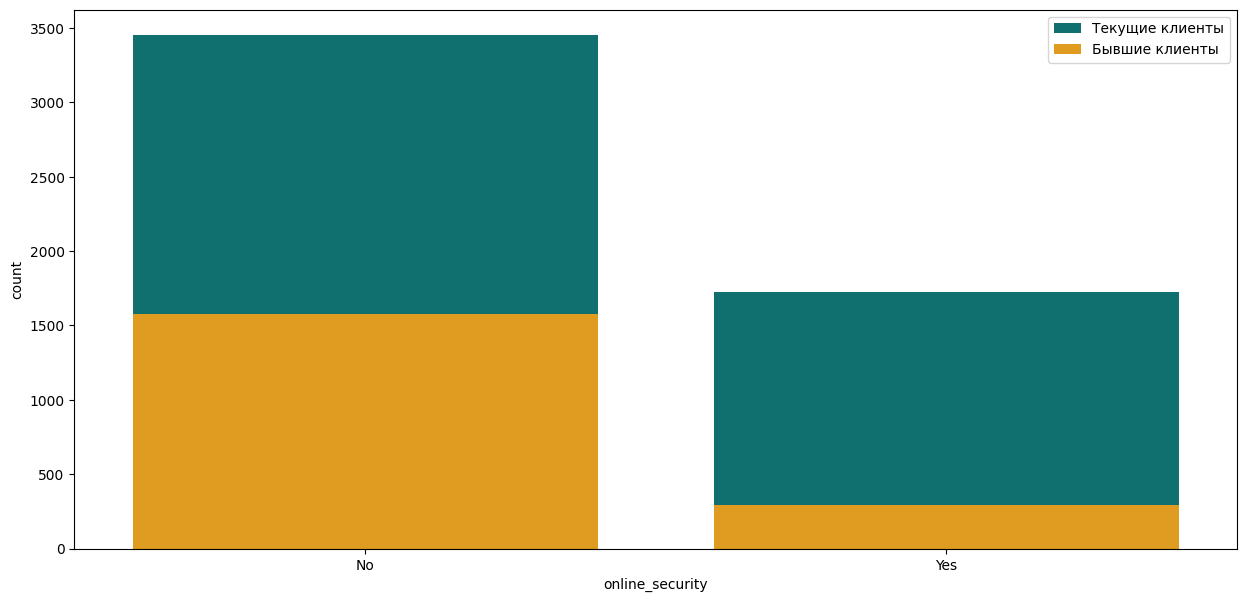

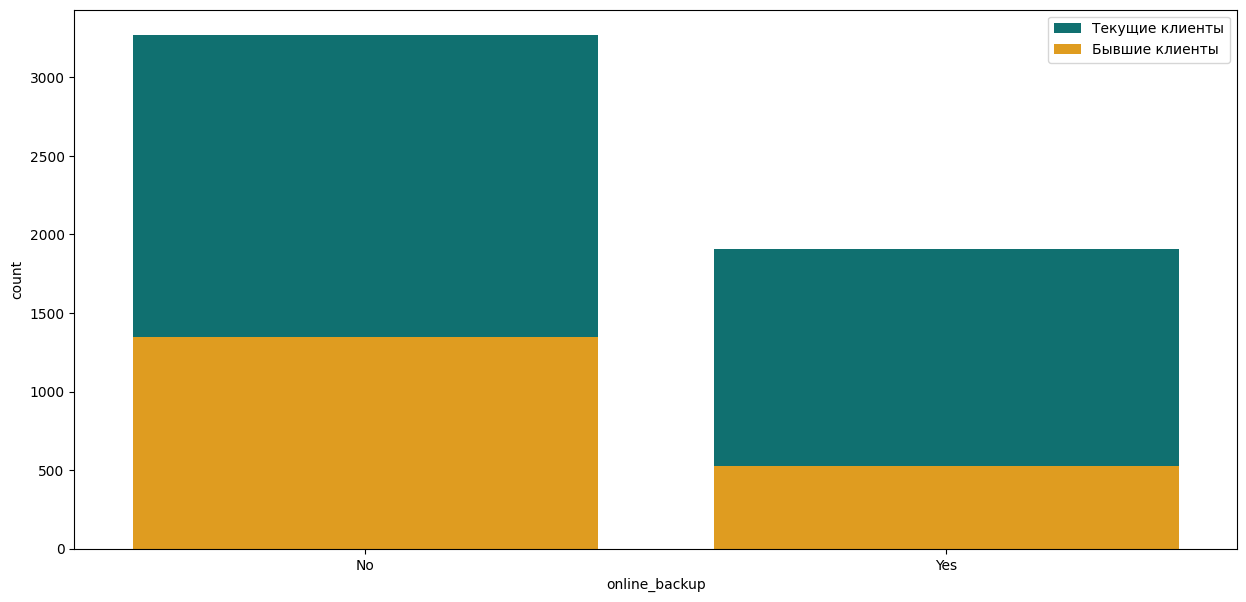

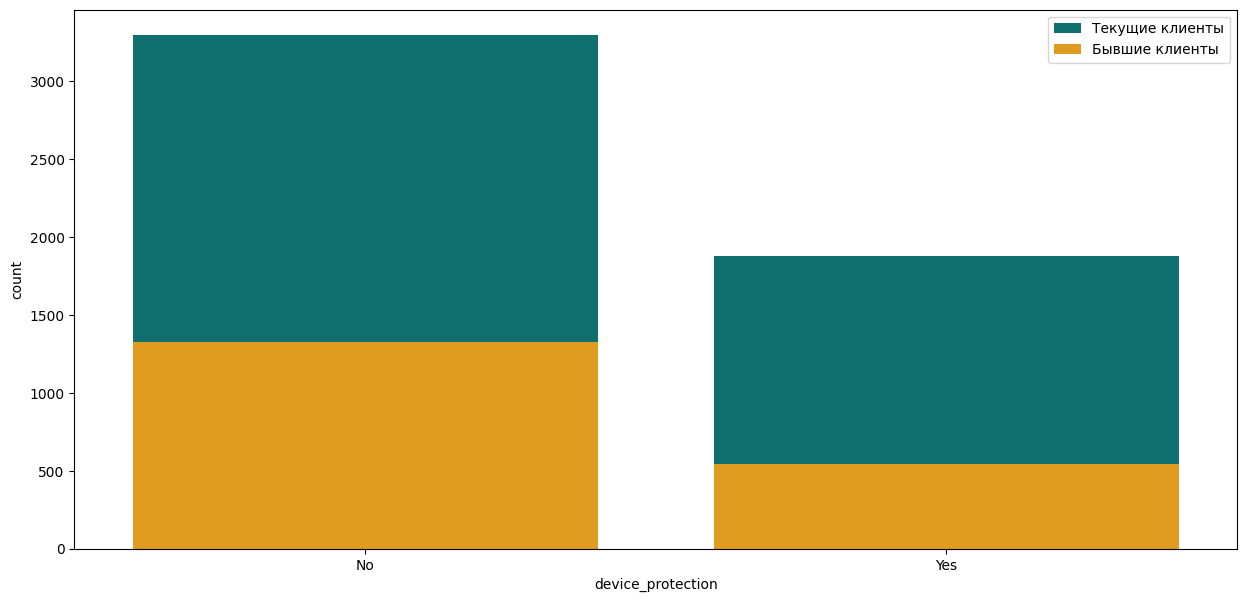

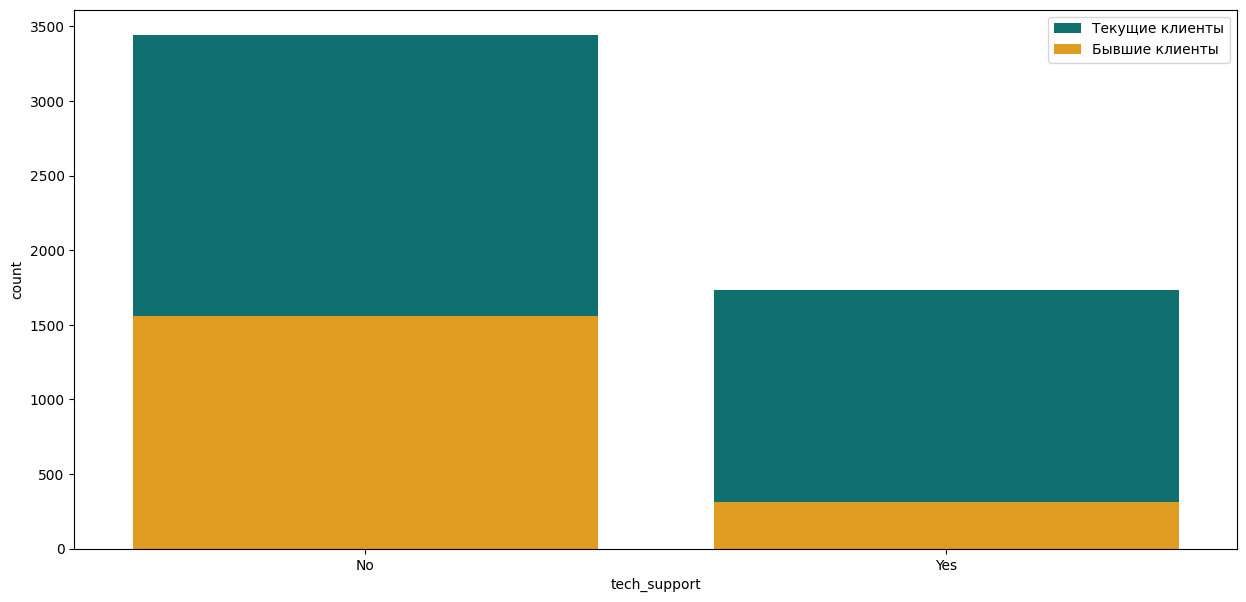

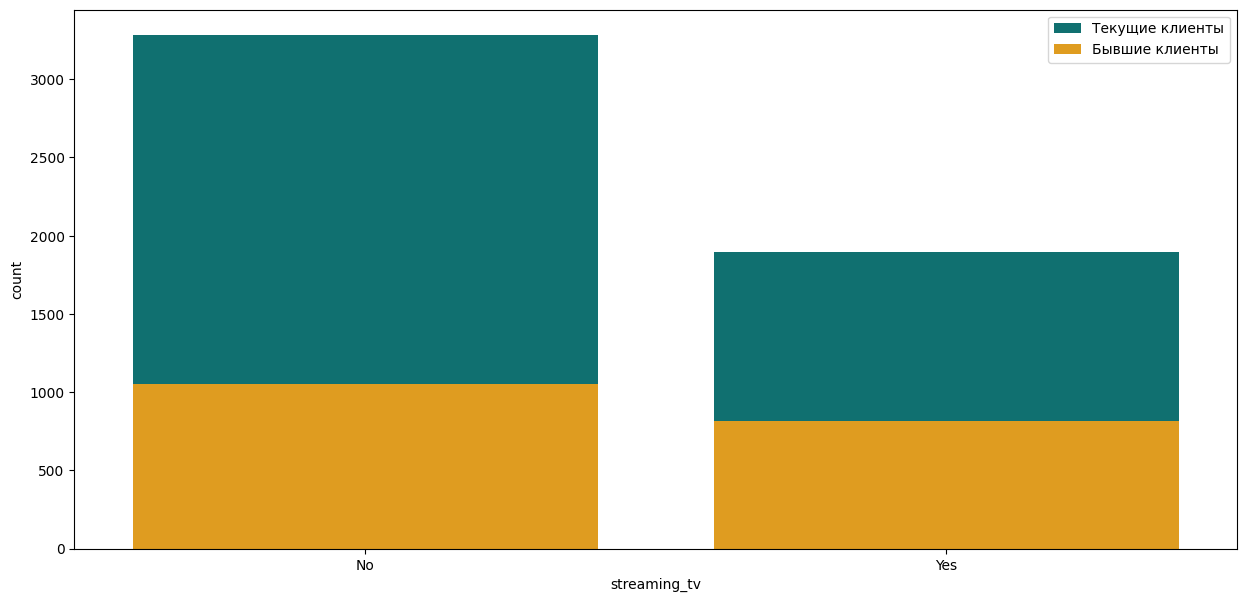

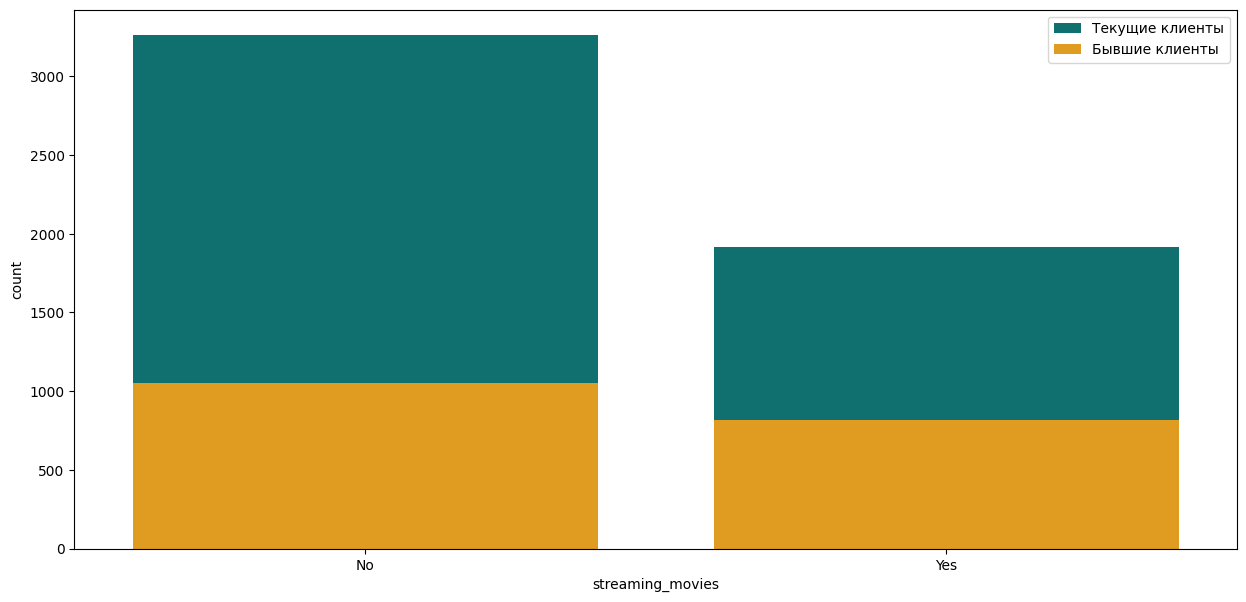

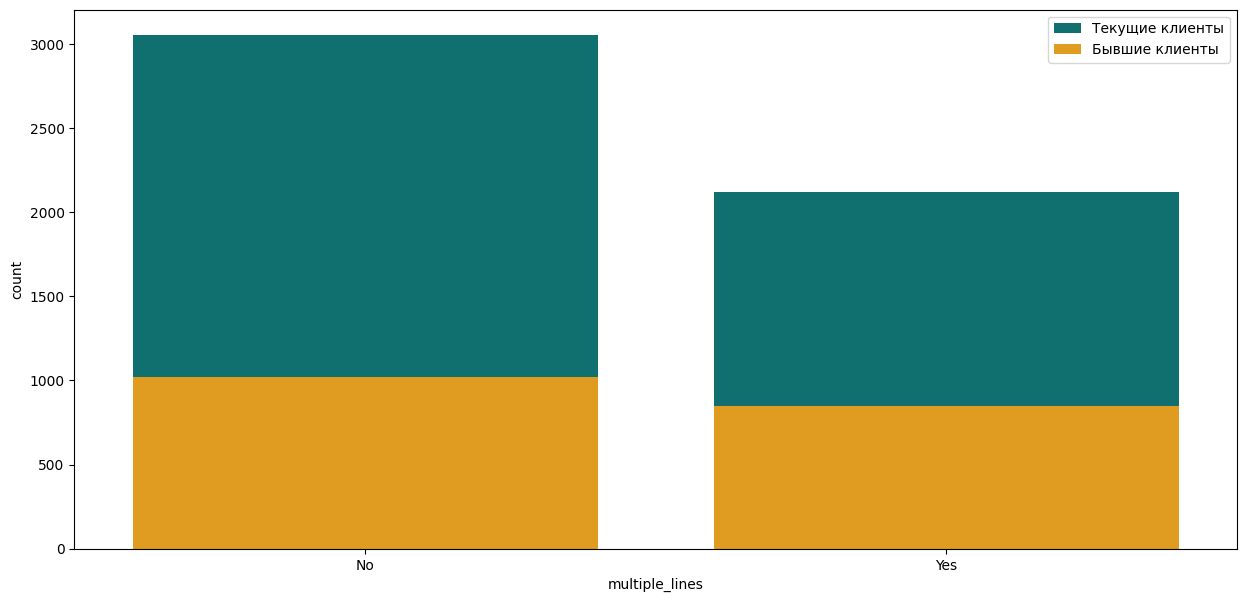

In [90]:
for column in columns_cat:

    plt.figure(figsize=(15, 7))

    sns.countplot(data=df_current.sort_values(column), x=column, color='teal', label='Текущие клиенты')
    sns.countplot(data=df_terminated.sort_values(column), x=column, color='orange', label='Бывшие клиенты')

    plt.legend()
    plt.show()

1. Большая часть ушедеших платило ежемесячно.
2. Большая часть ушедших получало счета онлайн.
3. Большая часть ушедших получала счета в электронном виде.
4. Не заметно существенное влияние гендера на вероятность ухода клиента.
5. Ушло много пожилых пользователей.
6. Клиенты у которых не тпартнера уходили чаще.
7. Клиенты у которых нет иждевенцев уходили чаще.
8. Большая часть ушедших использовало оптоволоконный интернет.
9. Большая часть ушедших не пользовалась дополнительными интернет услугами.
10. Не заметно существенное влияние наличия нескольких подключенных линий к телефону на вероятность ухода клиента.

## Дисбаланс классов

In [91]:
df['terminated_contract'].value_counts(normalize=True)

0   0.735
1   0.265
Name: terminated_contract, dtype: float64

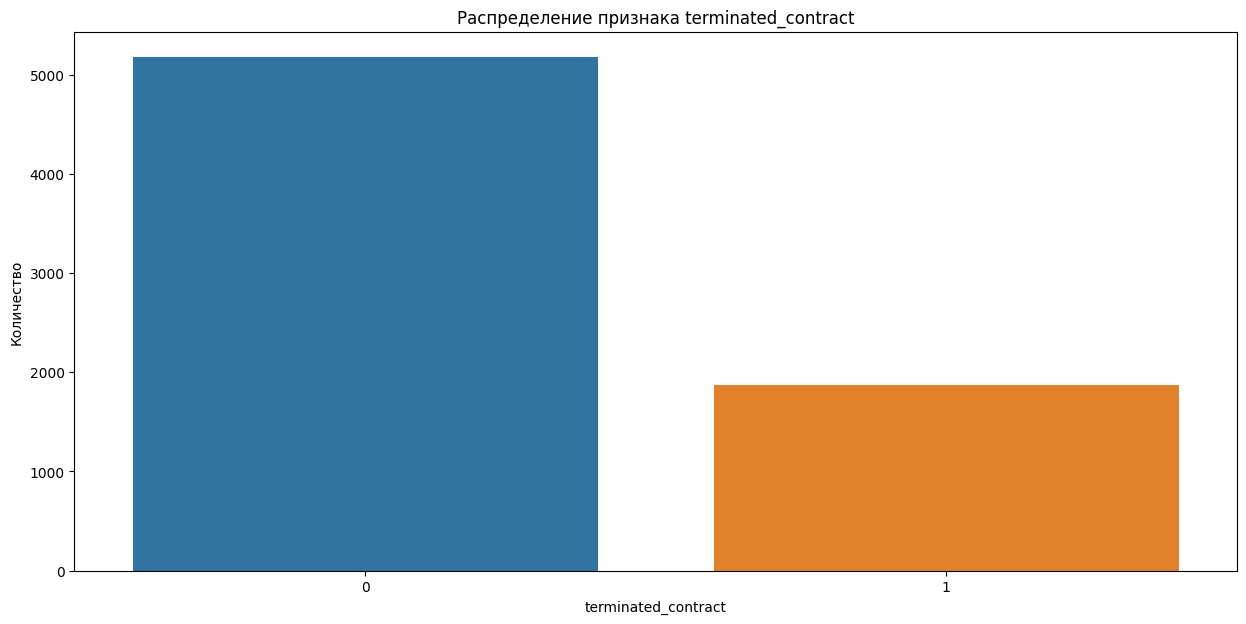

In [92]:
plt.figure(figsize=(15, 7))

sns.countplot(x=df_contract['terminated_contract']).set(title=('Распределение признака terminated_contract'),
                                                        ylabel='Количество')

plt.show()

Наблюдаем сильный дисбаланс классов.

Возможные методы борьбы с этим:
* Upsample;
* Downsample;
* Class Weight.

В целом выбранная метрика ROC-AUC - устойчива к дисбалансу классов.

При upsample может произойти утечка данных при кросс-валидации, для downsample датасет малого размеры, таким образом добавим в обучении модели балансировку весов.

## Разделение на признаки и таргет.

In [93]:
features = df.drop('terminated_contract', axis=1)
target = df['terminated_contract']

display(features.head())
print(target.head())

,type,paperless_billing,payment_method,monthly_charges,total_charges,timedelta,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
7590-VHVEG,Month-to-month,Yes,Electronic check,29.850,29.850,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.950,1889.500,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.850,108.150,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.300,1840.750,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.700,151.650,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


7590-VHVEG    0
5575-GNVDE    0
3668-QPYBK    1
7795-CFOCW    0
9237-HQITU    1
Name: terminated_contract, dtype: int64


## Проверка на мультиколлинеарность

Так как данные не распределны нормально, нельзя использовать метод Пирсона. Между Кендаллом и Спирменом выберем метод Кендалла, так как он считается более надежным и предпочтительным из двух.

In [94]:
corr_table = features[columns_cont].corr(method='kendall')
corr_table

,monthly_charges,total_charges,timedelta
monthly_charges,1.000,0.460,0.188
total_charges,0.460,1.000,0.731
timedelta,0.188,0.731,1.000


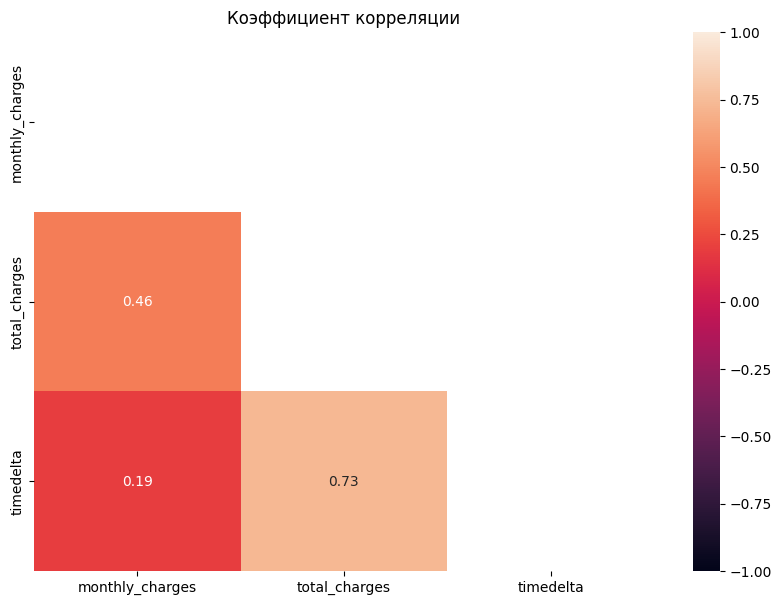

In [95]:
plt.figure(figsize=(10,7))

mask = np.triu(np.ones_like(corr_table, dtype=bool))

sns.heatmap(corr_table, annot=True, mask=mask, vmin=-1, vmax=1).set(title=('Коэффициент корреляции'))

plt.show()

Видим высокий коэффициент корреляции между количеством дней с заключения контракта и суммарном платеже. Это имеет смысл, так как чем дольше длится контракт тем больше ежемесячных платежей сделает клиент, что увеличит суммарный платеж.

Также заметна корреляция между ежемесячным платежом и суммарным платежом.

Посчитаем VIF.

In [96]:
def compute_vif(df, considered_features):

    X = df[considered_features]

    X['intercept'] = 1

    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [97]:
considered_features = ['monthly_charges', 'total_charges', 'timedelta']

In [98]:
compute_vif(df, considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
1,total_charges,9.511
2,timedelta,5.836
0,monthly_charges,3.218


Считается что VIF больше 5-10 это показатель сильной коллинеарности.

Наибольший VIF у признака total_charges, посмотрим как поменяется VIF если его убрать.

In [99]:
considered_features.remove('total_charges')

compute_vif(df, considered_features)

,Variable,VIF
0,monthly_charges,1.065
1,timedelta,1.065


VIF меньше 5.

Удалим признак total_charges.

In [100]:
features = features.drop('total_charges', axis=1)
features.head()

,type,paperless_billing,payment_method,monthly_charges,timedelta,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
7590-VHVEG,Month-to-month,Yes,Electronic check,29.850,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.950,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.850,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.300,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.700,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


## Разделение выборок

In [101]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=target)

In [102]:
print(features.shape)
print(features_train.shape, features_test.shape)
print(target_train.shape, target_test.shape)

(7043, 17)
(5282, 17) (1761, 17)
(5282,) (1761,)


## Подготовка признаков

Подготовим отдельные датасеты для разных методов:
1. LogisticRegression, Keras - MinMaxScaler + OHE;
2. RandomForestClassifier - LE;
3. CatBoostClassifier - ничего.

### MinMaxScaler + OHE

In [103]:
columns_to_encode = list(features.select_dtypes('object').columns)
columns_to_encode = columns_to_encode + ['senior_citizen']
columns_to_encode

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'senior_citizen']

In [104]:
columns_to_scale = list(features.drop('senior_citizen', axis=1).select_dtypes(['int', 'float']).columns)
columns_to_scale

['monthly_charges', 'timedelta']

Применим MinMaxScaler.

In [105]:
scaler = MinMaxScaler()

In [106]:
features_train_sc = features_train.copy()
features_test_sc = features_test.copy()

features_train_sc[columns_to_scale] = scaler.fit_transform(features_train_sc[columns_to_scale])
features_test_sc[columns_to_scale] = scaler.transform(features_test_sc[columns_to_scale])

display(features_train_sc.head())
display(features_test_sc.head())

,type,paperless_billing,payment_method,monthly_charges,timedelta,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
6705-LXORM,Month-to-month,No,Electronic check,0.515,0.070,Female,1,Yes,No,Fiber optic,No,No,No,No,No,No,No
7541-YLXCL,One year,Yes,Mailed check,0.468,0.500,Male,0,No,No,DSL,No,Yes,No,Yes,No,Yes,No
7876-BEUTG,Month-to-month,Yes,Mailed check,0.303,0.209,Female,0,No,No,DSL,No,No,No,No,No,No,Yes
4902-OHLSK,Month-to-month,No,Electronic check,0.800,0.403,Female,1,No,No,Fiber optic,No,No,No,Yes,Yes,Yes,Yes
8109-YUOHE,One year,No,Mailed check,0.376,0.236,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


,type,paperless_billing,payment_method,monthly_charges,timedelta,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
7055-HNEOJ,Month-to-month,Yes,Mailed check,0.373,0.042,Male,0,Yes,No,DSL,No,No,Yes,Yes,No,No,No
6719-FGEDO,Two year,Yes,Bank transfer (automatic),0.783,1.000,Female,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,No,No,Yes
5955-ERIHD,Month-to-month,Yes,Electronic check,0.760,0.250,Male,0,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Yes
9758-MFWGD,One year,No,Bank transfer (automatic),0.115,0.667,Female,1,Yes,Yes,DSL,No,Yes,No,No,No,No,No
9992-RRAMN,Month-to-month,Yes,Electronic check,0.665,0.305,Male,0,Yes,No,Fiber optic,No,No,No,No,No,Yes,Yes


Применим OHE.

In [107]:
oh_enc = OneHotEncoder(handle_unknown='ignore')

In [108]:
features_train_sc_ohe = features_train_sc.copy()
features_test_sc_ohe = features_test_sc.copy()

features_train_sc_ohe = oh_enc.fit_transform(features_train_sc_ohe[columns_to_encode])
features_test_sc_ohe = oh_enc.transform(features_test_sc_ohe[columns_to_encode])

print(features_train_sc_ohe.shape)
print('')
print(features_test_sc_ohe.shape)

(5282, 34)

(1761, 34)


### LabelEncoder

Применим LabelEncoder.

In [109]:
l_enc = LabelEncoder()

In [110]:
features_train_le = features_train.copy()
features_train_le[columns_to_encode] = features_train_le[columns_to_encode].apply(LabelEncoder().fit_transform)
display(features_train.head())
display(features_train_le.head())
print('')
print(len(features_train) == len(features_train_le))
print('')
print('')

features_test_le = features_test.copy()
features_test_le[columns_to_encode] = features_test_le[columns_to_encode].apply(LabelEncoder().fit_transform)
display(features_test.head())
display(features_test_le.head())
print('')
print(len(features_test) == len(features_test_le))

,type,paperless_billing,payment_method,monthly_charges,timedelta,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
6705-LXORM,Month-to-month,No,Electronic check,70.050,153,Female,1,Yes,No,Fiber optic,No,No,No,No,No,No,No
7541-YLXCL,One year,Yes,Mailed check,65.400,1095,Male,0,No,No,DSL,No,Yes,No,Yes,No,Yes,No
7876-BEUTG,Month-to-month,Yes,Mailed check,48.800,457,Female,0,No,No,DSL,No,No,No,No,No,No,Yes
4902-OHLSK,Month-to-month,No,Electronic check,98.650,883,Female,1,No,No,Fiber optic,No,No,No,Yes,Yes,Yes,Yes
8109-YUOHE,One year,No,Mailed check,56.100,518,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


,type,paperless_billing,payment_method,monthly_charges,timedelta,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
6705-LXORM,0,0,2,70.050,153,0,1,1,0,1,0,0,0,0,0,0,0
7541-YLXCL,1,1,3,65.400,1095,1,0,0,0,0,0,1,0,1,0,1,0
7876-BEUTG,0,1,3,48.800,457,0,0,0,0,0,0,0,0,0,0,0,1
4902-OHLSK,0,0,2,98.650,883,0,1,0,0,1,0,0,0,1,1,1,1
8109-YUOHE,1,0,3,56.100,518,1,0,0,0,0,1,1,0,0,0,0,0



True




,type,paperless_billing,payment_method,monthly_charges,timedelta,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
7055-HNEOJ,Month-to-month,Yes,Mailed check,55.800,92,Male,0,Yes,No,DSL,No,No,Yes,Yes,No,No,No
6719-FGEDO,Two year,Yes,Bank transfer (automatic),97.000,2191,Female,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,No,No,Yes
5955-ERIHD,Month-to-month,Yes,Electronic check,94.700,548,Male,0,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Yes
9758-MFWGD,One year,No,Bank transfer (automatic),29.900,1461,Female,1,Yes,Yes,DSL,No,Yes,No,No,No,No,No
9992-RRAMN,Month-to-month,Yes,Electronic check,85.100,668,Male,0,Yes,No,Fiber optic,No,No,No,No,No,Yes,Yes


,type,paperless_billing,payment_method,monthly_charges,timedelta,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
7055-HNEOJ,0,1,3,55.800,92,1,0,1,0,0,0,0,1,1,0,0,0
6719-FGEDO,2,1,0,97.000,2191,0,0,1,0,1,1,1,1,1,0,0,1
5955-ERIHD,0,1,2,94.700,548,1,0,1,0,1,0,0,0,0,1,1,1
9758-MFWGD,1,0,0,29.900,1461,0,1,1,1,0,0,1,0,0,0,0,0
9992-RRAMN,0,1,2,85.100,668,1,0,1,0,1,0,0,0,0,0,1,1



True


## Вывод

1. Выполнено объединение датафреймов.
2. Отброшены признаки begind_date, end_date.
3. Датафрейм разделен на признаки и таргет.
4. Признаки проверены на мультиколлинеарность, добавленный ранее признак timedelta удалён.
5. Выполнено разделение на обучающую и тестовую выборку.
6. Признаки подготовлены:
    * LogisticRegression, Keras - MinMaxScaler + OHE;
    * RandomForestClassifier - LE.

# Обучение моделей

## LogisticRegression

In [111]:
model_lr = LogisticRegressionCV(solver='liblinear', max_iter=10000, cv=5, class_weight='balanced', random_state=RANDOM_STATE)

In [112]:
model_lr.fit(features_train_sc_ohe, target_train)

LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=10000,
                     random_state=300123, solver='liblinear')

In [113]:
metrics = pd.Series(['Модель', 'AUC-ROC', 'Время обучения', 'Время предсказания']).rename('metrics')

In [114]:
_ = time.perf_counter()
model_lr.fit(features_train_sc_ohe, target_train)
time_fit_lr = time.perf_counter() - _

_ = time.perf_counter()
model_lr.predict(features_train_sc_ohe)
time_pred_lr = time.perf_counter() - _

In [115]:
roc_auc_lr = cross_val_score(model_lr, features_train_sc_ohe, target_train, cv = 5, scoring = 'roc_auc').mean()

In [116]:
lr_metrics = pd.Series(['LogisticRegression', roc_auc_lr, time_fit_lr, time_pred_lr]).rename('lr')
df_metrics = pd.concat([metrics, lr_metrics], axis=1)

In [117]:
df_metrics

,metrics,lr
0,Модель,LogisticRegression
1,AUC-ROC,0.825
2,Время обучения,1.730
3,Время предсказания,0.001


## RandomForestClassifier

In [118]:
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)

In [119]:
max_depth_rfc = [2, 4, 6, 8, 10]
n_estimators_rfc = list(range(50, 101, 5))

param_dis_rfc = {'max_depth': max_depth_rfc,
                 'n_estimators': n_estimators_rfc}

grid_search_rfc = GridSearchCV(estimator=model_rfc,
                               param_grid = param_dis_rfc,
                               cv=5,
                               n_jobs=1,
                               verbose=3,
                               scoring='roc_auc')

grid_search_rfc.fit(features_train_le, target_train)

print('Лучшие параметры:', grid_search_rfc.best_params_)

Fitting 5 folds for each of 55 candidates, totalling 275 fits
[CV 1/5] END ......max_depth=2, n_estimators=50;, score=0.831 total time=   0.5s
[CV 2/5] END ......max_depth=2, n_estimators=50;, score=0.823 total time=   0.3s
[CV 3/5] END ......max_depth=2, n_estimators=50;, score=0.834 total time=   0.3s
[CV 4/5] END ......max_depth=2, n_estimators=50;, score=0.837 total time=   0.3s
[CV 5/5] END ......max_depth=2, n_estimators=50;, score=0.843 total time=   0.4s
[CV 1/5] END ......max_depth=2, n_estimators=55;, score=0.830 total time=   0.4s
[CV 2/5] END ......max_depth=2, n_estimators=55;, score=0.825 total time=   0.4s
[CV 3/5] END ......max_depth=2, n_estimators=55;, score=0.836 total time=   0.4s
[CV 4/5] END ......max_depth=2, n_estimators=55;, score=0.837 total time=   0.2s
[CV 5/5] END ......max_depth=2, n_estimators=55;, score=0.843 total time=   0.2s
[CV 1/5] END ......max_depth=2, n_estimators=60;, score=0.831 total time=   0.3s
[CV 2/5] END ......max_depth=2, n_estimators=60

In [120]:
best_max_depth_rfc = grid_search_rfc.best_params_['max_depth']
best_n_estimators_rfc = grid_search_rfc.best_params_['n_estimators']

print(best_max_depth_rfc, best_n_estimators_rfc)

6 80


In [121]:
model_rfc_best = RandomForestClassifier(max_depth=best_max_depth_rfc, n_estimators=best_n_estimators_rfc, random_state=RANDOM_STATE)

In [122]:
model_rfc_best.fit(features_train_sc_ohe, target_train)

RandomForestClassifier(max_depth=6, n_estimators=80, random_state=300123)

In [123]:
_ = time.perf_counter()
model_rfc_best.fit(features_train_sc_ohe, target_train)
time_fit_rfc_best = time.perf_counter() - _

_ = time.perf_counter()
model_rfc_best.predict(features_train_sc_ohe)
time_pred_rfc_best = time.perf_counter() - _

In [124]:
roc_auc_rfc_best = grid_search_rfc.best_score_

In [125]:
rfc_best_metrics = pd.Series(['RandomForestClassifier', roc_auc_rfc_best, time_fit_rfc_best, time_pred_rfc_best]).rename('rfc')
df_metrics = pd.concat([df_metrics, rfc_best_metrics], axis=1)

In [126]:
df_metrics.iloc[:, [0, 2]]

,metrics,rfc
0,Модель,RandomForestClassifier
1,AUC-ROC,0.855
2,Время обучения,0.789
3,Время предсказания,0.083


## CatBoostClassifier

In [127]:
model_cbc = CatBoostClassifier(random_state=RANDOM_STATE,
                               eval_metric='AUC',
                               cat_features=columns_to_encode,
                               verbose=500,
                               auto_class_weights='Balanced')

In [128]:
grid_params_cbc = {'learning_rate': [0.007, 0.01, 0.03],
                   'depth': [5, 7, 10]}

grid_search_cbc = GridSearchCV(estimator=model_cbc,
                               cv=5,
                               param_grid = grid_params_cbc,
                               n_jobs=1,
                               verbose=3,
                               scoring='roc_auc')

grid_search_cbc.fit(features_train, target_train)

print('Лучшие параметры:', grid_search_cbc.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0:	total: 63.7ms	remaining: 1m 3s
500:	total: 3.27s	remaining: 3.25s
999:	total: 6.29s	remaining: 0us
[CV 1/5] END ......depth=5, learning_rate=0.007;, score=0.850 total time=   6.5s
0:	total: 7.65ms	remaining: 7.64s
500:	total: 3.08s	remaining: 3.06s
999:	total: 8.92s	remaining: 0us
[CV 2/5] END ......depth=5, learning_rate=0.007;, score=0.860 total time=   9.1s
0:	total: 16.4ms	remaining: 16.3s
500:	total: 4.18s	remaining: 4.16s
999:	total: 8.57s	remaining: 0us
[CV 3/5] END ......depth=5, learning_rate=0.007;, score=0.862 total time=   8.8s
0:	total: 14.8ms	remaining: 14.8s
500:	total: 6.91s	remaining: 6.88s
999:	total: 12.6s	remaining: 0us
[CV 4/5] END ......depth=5, learning_rate=0.007;, score=0.870 total time=  12.9s
0:	total: 7.92ms	remaining: 7.91s
500:	total: 3.03s	remaining: 3.01s
999:	total: 5.98s	remaining: 0us
[CV 5/5] END ......depth=5, learning_rate=0.007;, score=0.872 total time=   6.2s
0:	total: 7.53ms	remainin

In [129]:
best_depth_cbc = grid_search_cbc.best_params_['depth']
best_learning_rate_cbc = grid_search_cbc.best_params_['learning_rate']

print(best_depth_cbc, best_learning_rate_cbc)

5 0.03


In [130]:
model_cbc_best = CatBoostClassifier(random_state=RANDOM_STATE,
                                    eval_metric='AUC',
                                    cat_features=columns_to_encode,
                                    verbose=100,
                                    auto_class_weights='Balanced',
                                    depth=best_depth_cbc,
                                    learning_rate=best_learning_rate_cbc)

In [131]:
model_cbc_best.fit(features_train, target_train)

0:	total: 10.4ms	remaining: 10.4s
100:	total: 745ms	remaining: 6.63s
200:	total: 1.5s	remaining: 5.94s
300:	total: 2.2s	remaining: 5.1s
400:	total: 2.95s	remaining: 4.41s
500:	total: 3.76s	remaining: 3.74s
600:	total: 4.55s	remaining: 3.02s
700:	total: 5.35s	remaining: 2.28s
800:	total: 6.55s	remaining: 1.63s
900:	total: 8.3s	remaining: 912ms
999:	total: 10.1s	remaining: 0us


In [132]:
_ = time.perf_counter()
model_cbc_best.fit(features_train, target_train)
time_fit_cbc_best = time.perf_counter() - _

_ = time.perf_counter()
model_cbc_best.predict(features_train)
time_pred_cbc_best = time.perf_counter() - _

0:	total: 21.2ms	remaining: 21.1s
100:	total: 1.6s	remaining: 14.3s
200:	total: 3.14s	remaining: 12.5s
300:	total: 3.85s	remaining: 8.95s
400:	total: 4.63s	remaining: 6.91s
500:	total: 5.42s	remaining: 5.4s
600:	total: 6.21s	remaining: 4.12s
700:	total: 7s	remaining: 2.99s
800:	total: 7.8s	remaining: 1.94s
900:	total: 8.63s	remaining: 949ms
999:	total: 9.45s	remaining: 0us


In [133]:
roc_auc_cbc_best = grid_search_cbc.best_score_

In [134]:
cbc_metrics = pd.Series(['CatBoostClassifier', roc_auc_cbc_best, time_fit_cbc_best, time_pred_cbc_best]).rename('cbc')
df_metrics = pd.concat([df_metrics, cbc_metrics], axis=1)

In [135]:
cbc_metrics

0    CatBoostClassifier
1                 0.899
2                 9.642
3                 0.028
Name: cbc, dtype: object

In [136]:
df_metrics.iloc[:, [0, 3]]

,metrics,cbc
0,Модель,CatBoostClassifier
1,AUC-ROC,0.899
2,Время обучения,9.642
3,Время предсказания,0.028


## Keras

In [137]:
def model_builder(hp):
    model_kt = Sequential()

    unit_input = hp.Int('unit_input', min_value=10, max_value=100, step=10)
    model_kt.add(keras.layers.Dense(units=unit_input, input_dim=features_train_sc_ohe.shape[1], activation='relu'))
    model_kt.add(keras.layers.Dropout(0.2))

    for i in range(hp.Int('num_layers', 1, 4)):
        model_kt.add(keras.layers.Dense(units=hp.Int('unit_' + str(i),
                                                     min_value=10,
                                                     max_value=150,
                                                     step=10),
                                        activation='relu'))
        model_kt.add(keras.layers.Dropout(0.2))

    model_kt.add(keras.layers.Dense(units= 1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model_kt.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=keras.metrics.AUC(name='auc'))

    return model_kt

In [138]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('val_auc', 'max'),
                     max_epochs=10,
                     factor=3,
                     seed=RANDOM_STATE,
                     overwrite=True)

In [139]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [140]:
tuner.search(features_train_sc_ohe.toarray(), target_train, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 12s]
val_auc: 0.8270522952079773

Best val_auc So Far: 0.8433346748352051
Total elapsed time: 00h 02m 53s


In [141]:
tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_auc", direction="max")

Trial 0013 summary
Hyperparameters:
unit_input: 30
num_layers: 4
unit_0: 40
learning_rate: 0.001
unit_1: 40
unit_2: 70
unit_3: 40
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0005
Score: 0.8433346748352051


In [142]:
nn_best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [143]:
nn_layers = nn_best_hps.get('num_layers')

nn_unit_input = nn_best_hps.get('unit_input')

nn_unit_1 = nn_best_hps.get('unit_0')
nn_unit_2 = nn_best_hps.get('unit_1')
nn_unit_3 = nn_best_hps.get('unit_2')
nn_unit_4 = nn_best_hps.get('unit_3')

nn_learning_rate = nn_best_hps.get('learning_rate')

In [144]:
model_ks = tuner.hypermodel.build(nn_best_hps)
history = model_ks.fit(features_train_sc_ohe.toarray(), target_train, epochs=50, validation_split=0.25)

val_acc_per_epoch = history.history['val_auc']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Лучшая эпоха: %d' % (best_epoch,))

Epoch 1/50
124/124 [==============================] - 2s 7ms/step - loss: 0.5454 - auc: 0.6465 - val_loss: 0.4668 - val_auc: 0.8356
Epoch 2/50
124/124 [==============================] - 1s 4ms/step - loss: 0.4740 - auc: 0.7880 - val_loss: 0.4532 - val_auc: 0.8370
Epoch 3/50
124/124 [==============================] - 1s 4ms/step - loss: 0.4605 - auc: 0.7978 - val_loss: 0.4448 - val_auc: 0.8370
Epoch 4/50
124/124 [==============================] - 1s 4ms/step - loss: 0.4610 - auc: 0.7972 - val_loss: 0.4434 - val_auc: 0.8381
Epoch 5/50
124/124 [==============================] - 1s 5ms/step - loss: 0.4519 - auc: 0.8079 - val_loss: 0.4483 - val_auc: 0.8363
Epoch 6/50
124/124 [==============================] - 1s 4ms/step - loss: 0.4505 - auc: 0.8097 - val_loss: 0.4436 - val_auc: 0.8364
Epoch 7/50
124/124 [==============================] - 0s 4ms/step - loss: 0.4513 - auc: 0.8081 - val_loss: 0.4393 - val_auc: 0.8369
Epoch 8/50
124/124 [==============================] - 0s 4ms/step - loss: 0.

In [145]:
model_ks_best = tuner.hypermodel.build(nn_best_hps)

model_ks_best.fit(features_train_sc_ohe.toarray(), target_train, epochs=best_epoch)

Epoch 1/4
166/166 [==============================] - 3s 5ms/step - loss: 0.5251 - auc: 0.7029
Epoch 2/4
166/166 [==============================] - 1s 5ms/step - loss: 0.4711 - auc: 0.7926
Epoch 3/4
166/166 [==============================] - 1s 3ms/step - loss: 0.4601 - auc: 0.8035
Epoch 4/4
166/166 [==============================] - 1s 3ms/step - loss: 0.4591 - auc: 0.8036


In [146]:
_ = time.perf_counter()
model_ks_best.fit(features_train_sc_ohe.toarray(), target_train, epochs=best_epoch)
time_fit_ks_best = time.perf_counter() - _

_ = time.perf_counter()
model_ks_best.predict(features_train_sc_ohe)
time_pred_ks_best = time.perf_counter() - _

Epoch 1/4
166/166 [==============================] - 1s 3ms/step - loss: 0.4577 - auc: 0.8073
Epoch 2/4
166/166 [==============================] - 1s 4ms/step - loss: 0.4490 - auc: 0.8153
Epoch 3/4
166/166 [==============================] - 1s 3ms/step - loss: 0.4456 - auc: 0.8187
Epoch 4/4
166/166 [==============================] - 0s 2ms/step


In [147]:
model_kc = Sequential([
    keras.layers.Dense(units=nn_unit_input, input_dim=features_train_sc_ohe.shape[1], activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=nn_unit_1, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=nn_unit_2, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=nn_unit_3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=nn_unit_4, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units= 1, activation='sigmoid')])

In [148]:
model_kc.compile(optimizer=keras.optimizers.Adam(learning_rate=nn_learning_rate),
                 loss='binary_crossentropy')

In [149]:
k_c = KerasClassifier(model=model_kc,
                      epochs=best_epoch)

In [150]:
roc_auc_ks_best = cross_val_score(k_c, features_train_sc_ohe.toarray(), target_train, cv = 5, scoring = 'roc_auc').mean()

Epoch 1/4
133/133 [==============================] - 1s 4ms/step - loss: 0.5480
Epoch 2/4
133/133 [==============================] - 1s 5ms/step - loss: 0.4786
Epoch 3/4
133/133 [==============================] - 1s 4ms/step - loss: 0.4585
Epoch 4/4
34/34 [==============================] - 0s 3ms/step


Epoch 1/4
133/133 [==============================] - 2s 3ms/step - loss: 0.5476
Epoch 2/4
133/133 [==============================] - 0s 3ms/step - loss: 0.4871
Epoch 3/4
133/133 [==============================] - 0s 3ms/step - loss: 0.4689
Epoch 4/4
34/34 [==============================] - 0s 2ms/step


Epoch 1/4
133/133 [==============================] - 1s 3ms/step - loss: 0.5590
Epoch 2/4
133/133 [==============================] - 0s 3ms/step - loss: 0.4897
Epoch 3/4
133/133 [==============================] - 0s 3ms/step - loss: 0.4707
Epoch 4/4
33/33 [==============================] - 0s 1ms/step


Epoch 1/4
133/133 [==============================] - 2s 5ms/step - loss: 0.5525
Epoch 2/4
133/133 [==============================] - 1s 5ms/step - loss: 0.4877
Epoch 3/4
133/133 [==============================] - 1s 5ms/step - loss: 0.4688
Epoch 4/4
33/33 [==============================] - 0s 2ms/step


Epoch 1/4
133/133 [==============================] - 1s 3ms/step - loss: 0.5537
Epoch 2/4
133/133 [==============================] - 0s 3ms/step - loss: 0.4818
Epoch 3/4
133/133 [==============================] - 0s 3ms/step - loss: 0.4726
Epoch 4/4
33/33 [==============================] - 0s 1ms/step


In [151]:
ks_metrics = pd.Series(['Keras', roc_auc_ks_best, time_fit_ks_best, time_pred_ks_best]).rename('ks')
df_metrics = pd.concat([df_metrics, ks_metrics], axis=1)

In [152]:
df_metrics.iloc[:, [0, 4]]

,metrics,ks
0,Модель,Keras
1,AUC-ROC,0.817
2,Время обучения,2.297
3,Время предсказания,0.532


## Вывод

In [153]:
df_metrics

,metrics,lr,rfc,cbc,ks
0,Модель,LogisticRegression,RandomForestClassifier,CatBoostClassifier,Keras
1,AUC-ROC,0.825,0.855,0.899,0.817
2,Время обучения,1.730,0.789,9.642,2.297
3,Время предсказания,0.001,0.083,0.028,0.532


1. Обучены модели:
    * LogisticRegression;
    * RandomForestClassifier;
    * CatBoostClassifier;
    * KerasSequential.
2. Наилучшие результаты на кросс-валидацим показала модель CatBoostClassifier. ROC-AUC = 0.899.

# Проверка финальной модели

## Сравнение выбранной модели с константной

Выберем модель CatBoostClassifier с ранее подобранными гиперпараметрами, проверим её на тестовых данных и сравним её с константной моделью.

CatBoost.

In [154]:
final_metrics = pd.Series(['Модель', 'AUC-ROC', 'Accuracy']).rename('final_metrics')

In [155]:
model_cbc_best.fit(features_train, target_train)

prediction_cbc_best = model_cbc_best.predict(features_test)
probabilities_cbc_best = model_cbc_best.predict_proba(features_test)
probabilities_one_cbc_best = probabilities_cbc_best[:, 1]

0:	total: 15.5ms	remaining: 15.5s
100:	total: 781ms	remaining: 6.95s
200:	total: 1.53s	remaining: 6.07s
300:	total: 2.26s	remaining: 5.24s
400:	total: 3.06s	remaining: 4.57s
500:	total: 3.9s	remaining: 3.88s
600:	total: 5.47s	remaining: 3.63s
700:	total: 7.27s	remaining: 3.1s
800:	total: 9.07s	remaining: 2.25s
900:	total: 10.9s	remaining: 1.2s
999:	total: 12s	remaining: 0us


In [156]:
roc_auc_cbc_best = roc_auc_score(target_test, probabilities_one_cbc_best)
print('ROC-AUC', roc_auc_cbc_best)

ROC-AUC 0.9126416105960967


ROC-AUC = 0.913, это выше порогового значения

In [157]:
accuracy_cbc_best = accuracy_score(target_test, prediction_cbc_best)
print('Accuracy:', accuracy_cbc_best)

Accuracy: 0.8285065303804656


In [158]:
cbc_final_metrics = pd.Series(['CatBoostClassifier', roc_auc_cbc_best, accuracy_cbc_best]).rename('cbc_final')

In [159]:
df_final_metrics = pd.concat([final_metrics, cbc_final_metrics], axis=1)
df_final_metrics

,final_metrics,cbc_final
0,Модель,CatBoostClassifier
1,AUC-ROC,0.913
2,Accuracy,0.829


Константная модель.

In [160]:
model_dc = DummyClassifier(strategy="most_frequent")

model_dc.fit(features_train, target_train)

prediction_dc = model_dc.predict(features_test)
probabilities_dc = model_dc.predict_proba(features_test)
probabilities_one_dc = probabilities_dc[:, 1]

In [161]:
roc_auc_dc = roc_auc_score(target_test, probabilities_one_dc)
print('AUC-ROC:', roc_auc_dc)

accuracy_dc = accuracy_score(target_test, prediction_dc)
print('Accuracy:', accuracy_dc)

AUC-ROC: 0.5
Accuracy: 0.7348097671777399


In [162]:
dc_final_metrics = pd.Series(['DummyClassifier', roc_auc_dc, accuracy_dc]).rename('dc_final')

In [163]:
df_final_metrics = pd.concat([df_final_metrics, dc_final_metrics], axis=1)
df_final_metrics.iloc[:, [0, 2]]

,final_metrics,dc_final
0,Модель,DummyClassifier
1,AUC-ROC,0.500
2,Accuracy,0.735


Сравним модели.

In [164]:
df_final_metrics

,final_metrics,cbc_final,dc_final
0,Модель,CatBoostClassifier,DummyClassifier
1,AUC-ROC,0.913,0.500
2,Accuracy,0.829,0.735


Выбранная модель адекватна, accuracy выше константной модели.

## Анализ других метрик выбранной модели

In [165]:
full_final_metrics = pd.Series(['Модель', 'AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1']).rename('full_final_metrics')

In [166]:
precision_cbc_best = precision_score(target_test, prediction_cbc_best)
recall_cbc_best = recall_score(target_test, prediction_cbc_best)
f1_cbc_best = f1_score(target_test, prediction_cbc_best)

print('Precision:', precision_cbc_best)
print('Recall:', recall_cbc_best)
print('F1:', f1_cbc_best)

Precision: 0.6354679802955665
Recall: 0.828693790149893
F1: 0.7193308550185874


In [167]:
cbc_full_final_metrics = pd.Series(['CatBoostClassifier',
                                    roc_auc_cbc_best,
                                    accuracy_cbc_best,
                                    precision_cbc_best,
                                    recall_cbc_best,
                                    f1_cbc_best]).rename('cbc_final')

In [168]:
df_full_final_metrics = pd.concat([full_final_metrics, cbc_full_final_metrics], axis=1)
df_full_final_metrics

,full_final_metrics,cbc_final
0,Модель,CatBoostClassifier
1,AUC-ROC,0.913
2,Accuracy,0.829
3,Precision,0.635
4,Recall,0.829
5,F1,0.719


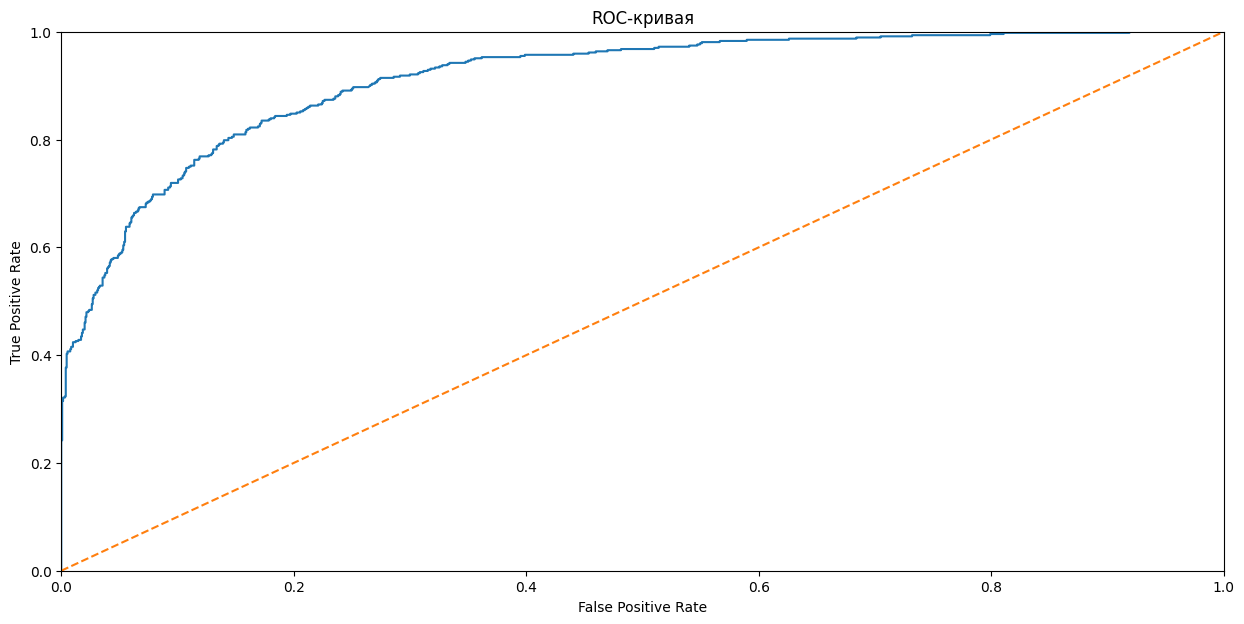

In [169]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_cbc_best)

plt.figure(figsize=(15,7))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

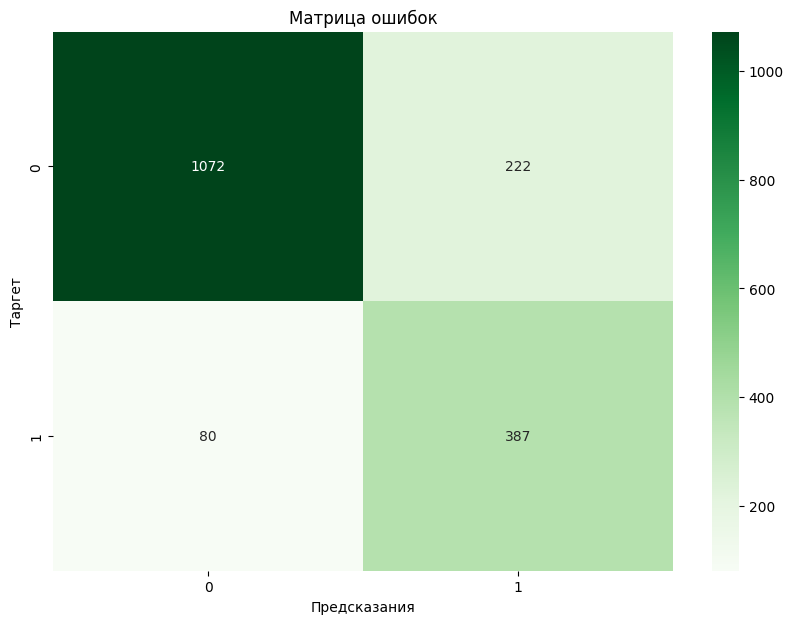

In [170]:
confusion_m = confusion_matrix(target_test, prediction_cbc_best)

plt.figure(figsize=(10,7))

sns.heatmap(confusion_m, annot=True, fmt='g', cmap='Greens').set(title=('Матрица ошибок'),
                                                                 xlabel='Предсказания',
                                                                 ylabel='Таргет')

plt.show()

1. ROC-AUC - превышает пороговый заданный заказчиком (0.85) и равен 0.913.
2. Accuracy - 0.829, выше чем у константной модели.
3. Precision (показатель того насколько точно модель разделяет true positive и true negative) - 0.635, средний, но для нашей задачи этот показатель менее важен чем recall.
4. Recall (показатель того насколько модель точно определяет все true positive) - 0.829, высокий. Так как задача модели определять клиентов которые собираются уйти этот показатель важнее чем Precision.
5. F1 (совокупный показатель precision и recall) - 0.719.
6. Матрица ошибок подтверждает показатели precision и recall, почти нету false negative, но есть большое количество false positive.

## Анализ важности признаков для выбранной модели

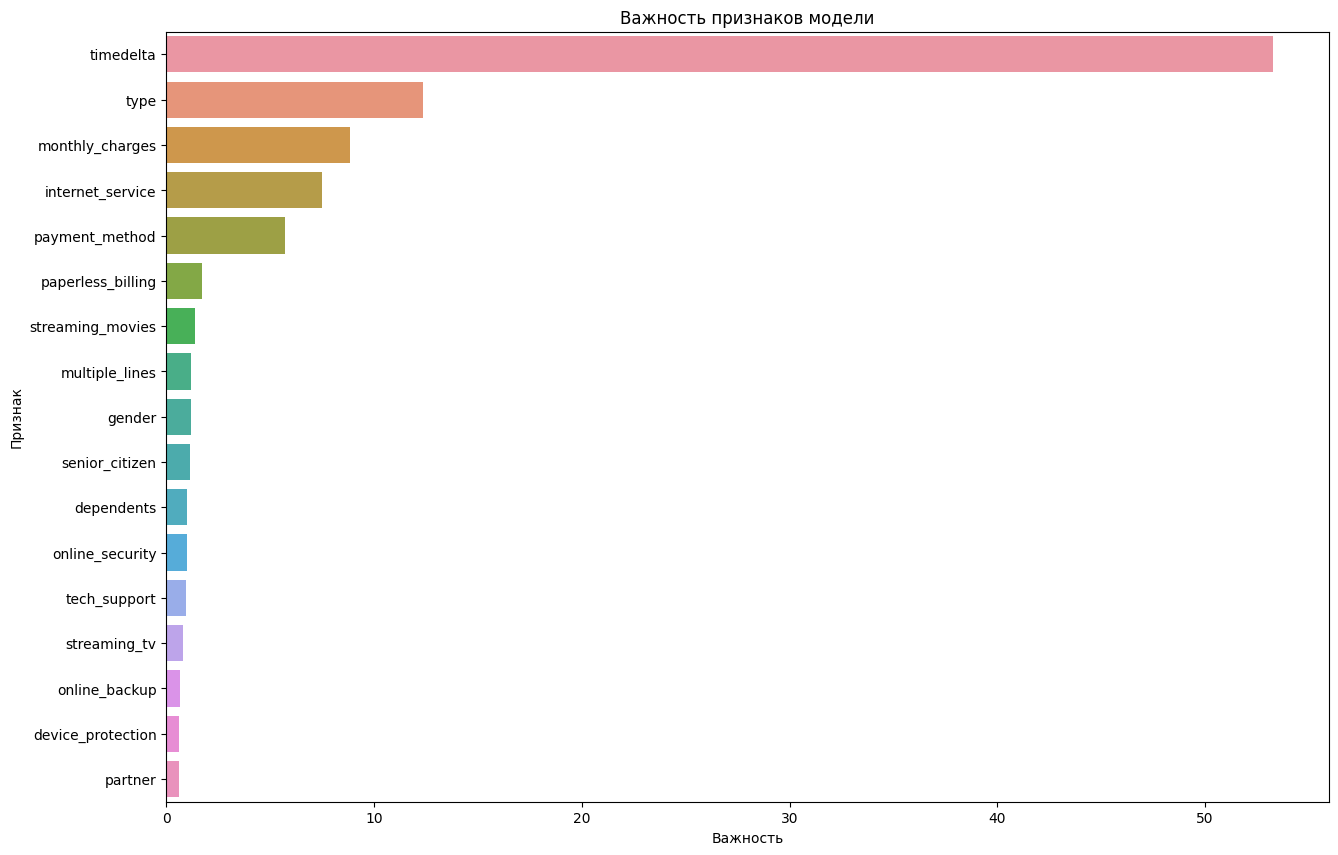

In [171]:
features_importance = pd.DataFrame({'Признак': features.columns,
                                    'Важность': model_cbc_best.feature_importances_}).sort_values('Важность', ascending=False)

plt.figure(figsize=(15, 10))

sns.barplot(data=features_importance, x='Важность', y='Признак').set(title=('Важность признаков модели'),
                                                                      xlabel='Важность',
                                                                      ylabel='Признак')

plt.show()

**Самые важные признаки для модели:**
* timedelta
* type;
* monthly_charges.

### Признак timedelta

In [172]:
print('Медианное количество дней с начала контракта у клиентов расторгнувших контракт')
print(df[df['terminated_contract'] == 1]['timedelta'].median())
print('')

print('Медианное количество дней с начала контракта у клиентов не расторгнувших контракт')
print(df[df['terminated_contract'] == 0]['timedelta'].median())
print('')

Медианное количество дней с начала контракта у клиентов расторгнувших контракт
304.0

Медианное количество дней с начала контракта у клиентов не расторгнувших контракт
1157.0



<ipython-input-173-77650fc99ad6>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_current['timedelta'], shade=True, color='teal', label='Текущие клиенты')
<ipython-input-173-77650fc99ad6>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_terminated['timedelta'], shade=True, color='orange', label='Бывшие клиенты')


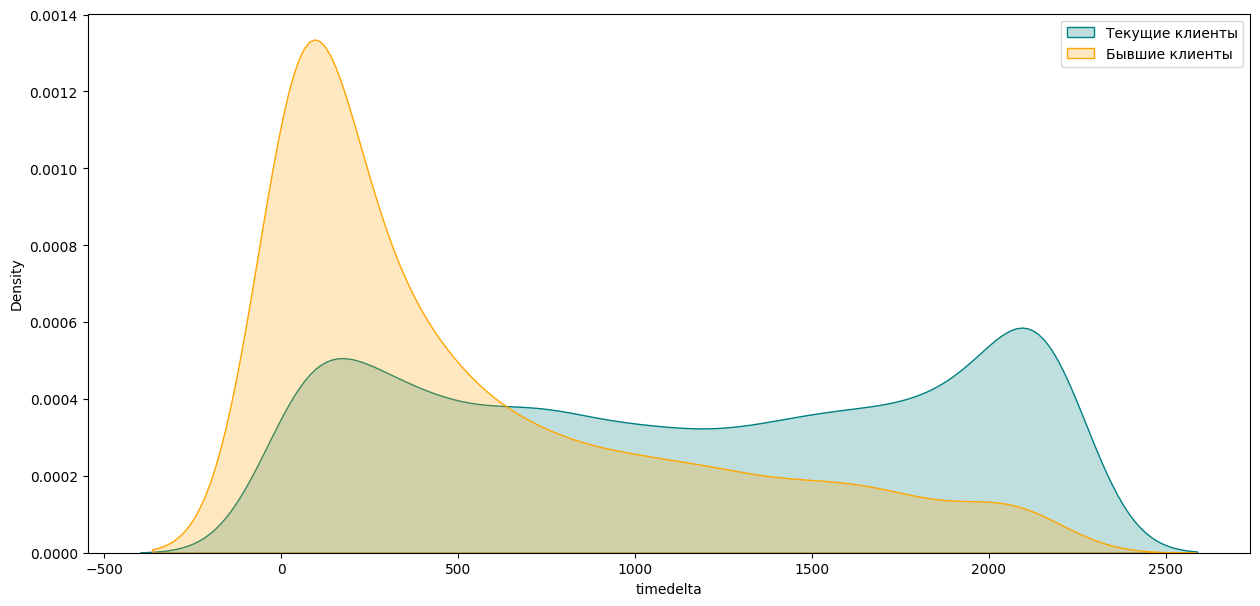

In [173]:
plt.figure(figsize=(15, 7))

sns.kdeplot(df_current['timedelta'], shade=True, color='teal', label='Текущие клиенты')
sns.kdeplot(df_terminated['timedelta'], shade=True, color='orange', label='Бывшие клиенты')

plt.legend()
plt.show()

Медианный количество дней с начала контракта у клиентов не расторгнувших контракт больше медианного суммарного количество дней с начала контракта у клиентов расторгнувших контракт почти в 4 раза. Т.е. чем дольше пользователя является клиентом тем меньше шансов, что он расторгнет контракт.

### Признак type

In [174]:
print('Распределение таргета для ежемесячных платежей')
print(df[df['type'] == 'Month-to-month']['terminated_contract'].value_counts(normalize=True))
print('')

print('Распределение таргета для ежегодных платежей')
print(df[df['type'] == 'One year']['terminated_contract'].value_counts(normalize=True))
print('')

print('Распределение таргета для платежей раз в два года')
print(df[df['type'] == 'Two year']['terminated_contract'].value_counts(normalize=True))

Распределение таргета для ежемесячных платежей
0   0.573
1   0.427
Name: terminated_contract, dtype: float64

Распределение таргета для ежегодных платежей
0   0.887
1   0.113
Name: terminated_contract, dtype: float64

Распределение таргета для платежей раз в два года
0   0.972
1   0.028
Name: terminated_contract, dtype: float64


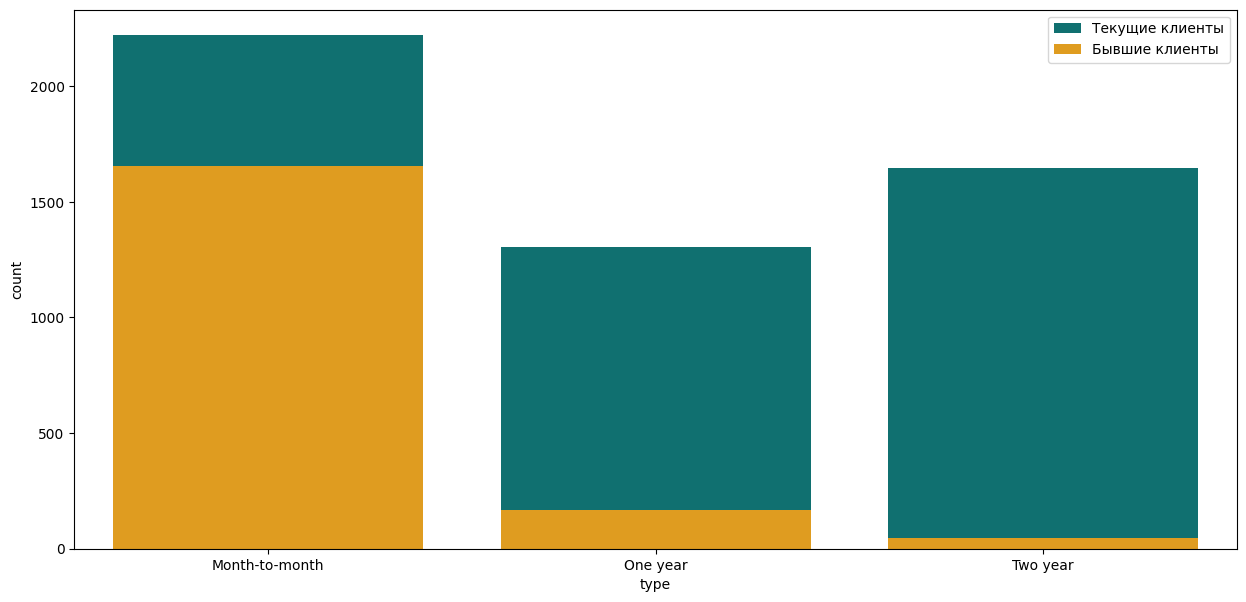

In [175]:
plt.figure(figsize=(15, 7))

sns.countplot(data=df_current.sort_values('type'), x='type', color='teal', label='Текущие клиенты')
sns.countplot(data=df_terminated.sort_values('type'), x='type', color='orange', label='Бывшие клиенты')

plt.legend()
plt.show()

Видим сильную зависимость между значениеми признака type и таргетом. Клиенты, которые платят каждый месяц часто расторгают контракты, клиенты которые оплачивают за два года почти не расторгают контракты.

### Признак monthly_charges

In [176]:
print('Медианный ежемесячный платеж у клиентов расторгнувших контракт')
print(round(df[df['terminated_contract'] == 1]['monthly_charges'].median(), 3))
print('')

print('Медианный ежемесячный платеж у клиентов не расторгнувших контракт')
print(round(df[df['terminated_contract'] == 0]['monthly_charges'].median(), 3))
print('')

Медианный ежемесячный платеж у клиентов расторгнувших контракт
79.65

Медианный ежемесячный платеж у клиентов не расторгнувших контракт
64.425



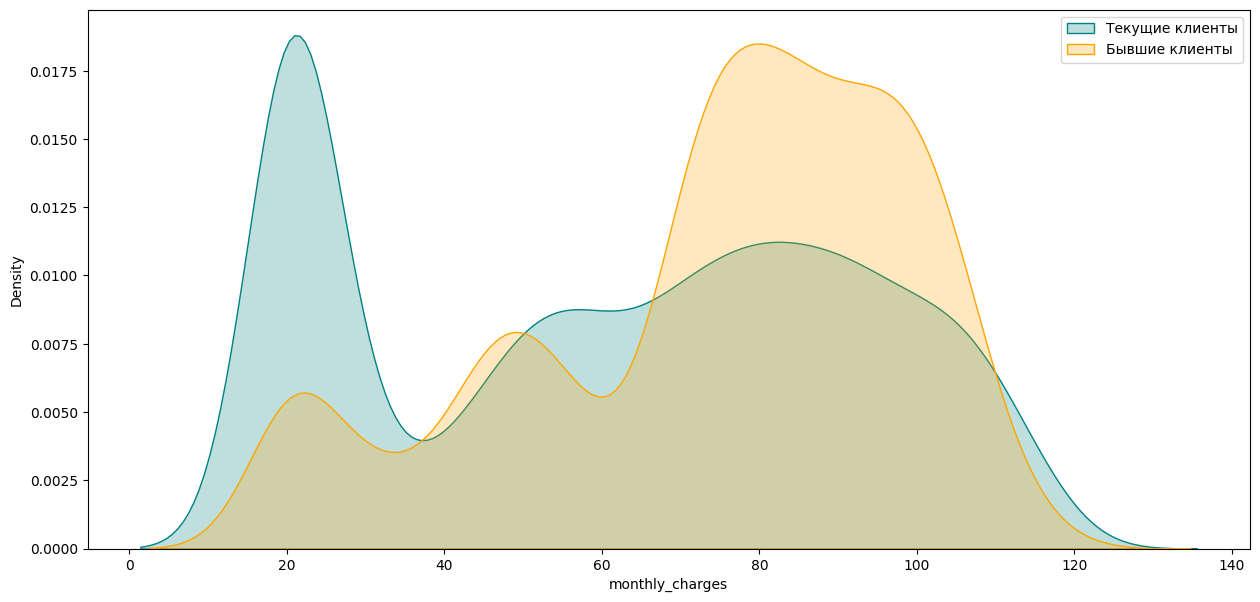

In [178]:
plt.figure(figsize=(15, 7))

sns.kdeplot(df_current['monthly_charges'], fill=True, color='teal', label='Текущие клиенты')
sns.kdeplot(df_terminated['monthly_charges'], fill=True, color='orange', label='Бывшие клиенты')

plt.legend()
plt.show()

Видим сильную зависимость между значениеми признаком monthly_charges и таргетом. Заметим, что медианный месячный платеж у клиентов которые остались с компанией меньше, чем у тех, которые ушли. Это пожтверждается и распределением.

## Вывод

1. Проведено сравнение выбранной модели CatBoostClassifier с константной моделью, accuracy выбраной модели выше константной - модель адекватна.
2. ROC-AUC - превышает пороговый заданный заказчиком (0.85) и равен 0.913. Что входит в диапазон "отлично" указанный заказчиком (>0.88).
3. Accuracy равен 0.829.
4. Precision равен 0.635.
5. Recall равен 0.829.
6. Выполнен анализ важности признаков для выбранной модели. Самые важные признаки:
    * timedelta;
    * type;
    * monthly_charges.

# Отчет

Была поставлена задача - построить модель машинного обучения, позволяющую прогнозировать отток клиентов с ROC-AUC на тестовой выборке не менее 0.85. Данная задача была полностью выполнена с ROC-AUC итоговой модели на тестовой выборке 0.913, что входит в диапазон "отлично" указанный заказчиком (>0.88).

1. Полученные от заказчика 4 датасета (данные контрактов, данные клиентов, данные использования услуг интернета и данные использования услуг телефонии) были успешно загружены для дальнейшего исследования.
2. Был проведен анализ полученных данных. Входе данного анализа каждый датасет рассматривался отдельно.
    1. Выполнена проверка на дубликаты и пропуски.
    2. Признаки приведены к нужным типам.
    3. Выделен таргет как новый признак.
    4. Создан признак показывающий сколько дней пользователь является клиентом компании.
    5. Найдены следующие закономерности:
        1. В последний год зарегистрировалось много новых пользователей;
        2. Все пользователи завершившие контракт ушли в период с 10.2019 по 01.2020. При этом 02.2020 - это неполный последний месяц датасета.
        3. Большинство пользователей не завершило контракт;
        4. Большинство пользователей предпочитают ежемесячный тариф;
        5. Большинство пользователей платят по электронному счету;
        6. Большое количество пользователей платят маленькую ежемесячную сумму, при это существует значительное количество клиентов с большой ежемесячной суммой платежа;
        7. Суммарный платеж имеет выраженный пик близко к 0, скорее всего это связано с притоком новых пользователей.:
        8. У большинства пользователей оптоволоконный интернет;
        9. Большинство пользователей малдше пенсионного возраста и не имеют иждевенцев.
        10. У большинства пользователей оптоволоконный интернет.
        11. Наименее популярные услуги: антивирус и линия выделенной техподдержки.
        12. У почти половины пользователей телефон подключен к нескольким линиям.
3. Была проведена подготовка данных для использования в модели.
    1. Все датасеты были объединены, выделены следующие признаки, которые будут использоваться для обучения:
        1. timedelta - сколько дней пользователь является клиентом компании;
        2. type - тип контракта по частоте платежа (ежемесяный, ежегодный, каждые два года);
        3. paperless_billing - выставляется электронный или бумажный счет;
        4. payment_method - метод оплаты;
        5. monthly_charges - ежемесячная плата;
        6. total_charges - суммарная плата за всё время;
        7. gender - гендер клиента;
        8. senior_citizen - является ли клиент пенсионером;
        9. partner - имеется ли у клиента партнёр;
        10. dependents - имеются ли у клиента иждевенцы;
        11. internet_service - тип интернета (оптоволокно и DSL);
        12. online_security - наличие услуги блокировки небезопасных сайтов;
        13. online_backup - наличие услуги облачного хранилища файлов для резервного копирования данных;
        14. device_protection - наличие услуги антивируса;
        15. tech_support - наличие услуги выделенной линии технической поддержки;
        16. streaming_tv - наличие услуги стримингового телевидения;
        17. streaming_movies - наличие услуги доступа к каталогу фильмов;
        18. multiple_lines - подключен ли телефон к нескольким линиям связи;
        19. is_terminated - целевой признак, показывающий ушёл ли клиент или нет.
    2. Исследована зависимость целевого признака от различных значений признаков.
    3. Проведено исследование баланса классов, выявлен дисбаланс целевого признака.
    4. Выполнена проверка на мультиколлинеарность, по её результатам убран признак total_charges.
    5. Данные разделены на выборки и подготовлены к использованию в моделях.
4. Было выполнено обучение 4 моделей. В итоге была выбрана модель CatBoostClassifier c гиперпараметрами 'depth': 5, 'learning_rate': 0.03. Данная модель перывашет заявленную заказчиком пороговую метрик ROC-AUC в 0.85. Метрика ROC-AUC данной модели составлет 0.913.
5. Была выполнена проверка модели на адекватность, которую модель успешно прошла. Было обнаружено что модель очень хорошо определяет всех клиентов, которые хотят уйти, при этом довольно часто ошибочно отмечает клиентов которые не хотят уходить как клиентов, которые потенциально расторгнут договор с компанией.
6. Выполнен анализ важности признаков для выбранной модели. Самые важные признаки:
    * timedelta;
    * type;
    * monthly_charges.

    

<b><font size="4">Ответы на вопросы</font></b>

1. Все пункты плана выполнены.
2. Возникли следующие трудности:
    * Подбор гиперпараметров Keras - потребовало изучение документации библиотеки keras_tuner и форумов;
    * Использование cross_val_score с Keras - потребовало изучения библиотеки scikeras и изучение форумов для нахождения похожих кейсов;
    * Доведение метрики до диапазона значений отлично - потребовало тщательного анализа и подготовки признаков, создания нового признака показывающего количество времени с заключения контракта клиентом, а также совета от тимлида сделать это признак по дням, а не по месяцам как он был сделан изначально.
3. Ключевые шаги:
    * Анализ данных;
    * Подготовка данных;
    * Обучение моделей;
    * Тестирование финальной модели.
4. Ответ на данный вопрос находится выше в отчете (пункт 3, подпункт 1).
5. Ответ на данный вопрос находится выше в отчете (пункт 4).

